<a href="https://colab.research.google.com/github/CarolinaBRangel/Lista_Machine-Learning/blob/main/Carolina_Rangel_Lista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core
import pandas as pd
import numpy as np
from scipy.stats import skew
from google.colab import files
import io

# Visual
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, ElasticNetCV 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats as st
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **EXERCÍCIO 1**

In [2]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['house-prices.csv']))

Saving house-prices.csv to house-prices (1).csv


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Colocando a variável dependente como primeira no Dataset

cols_to_order = ['SalePrice']
new_columns = cols_to_order + (df.columns.drop(cols_to_order).tolist())
df = df[new_columns]
df.head()

SalePrice  Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
0     208500   1          60       RL         65.0     8450   Pave   NaN   
1     181500   2          20       RL         80.0     9600   Pave   NaN   
2     223500   3          60       RL         68.0    11250   Pave   NaN   
3     140000   4          70       RL         60.0     9550   Pave   NaN   
4     250000   5          60       RL         84.0    14260   Pave   NaN   

  LotShape LandContour  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
0      Reg         Lvl  ...           0        0    NaN   NaN         NaN   
1      Reg         Lvl  ...           0        0    NaN   NaN         NaN   
2      IR1         Lvl  ...           0        0    NaN   NaN         NaN   
3      IR1         Lvl  ...           0        0    NaN   NaN         NaN   
4      IR1         Lvl  ...           0        0    NaN   NaN         NaN   

  MiscVal MoSold YrSold  SaleType  SaleCondition  
0       0      2   2008        WD         Normal  
1       0      5   2007        WD         Normal  
2       0      9   2008        WD         Normal  
3       0      2   2006        WD        Abnorml  
4       0     12   2008        WD         Normal  

[5 rows x 81 columns]

# Parte I: Tratamento dos Dados

## Missing values geral

In [5]:
total = df.isnull().sum().sort_values(ascending=False)

percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageFinish     81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageQual       81  0.055479
GarageCond       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrType        8  0.005479
MasVnrArea        8  0.005479
Electrical        1  0.000685
KitchenAbvGr      0  0.000000

Há algumas variáveis que tem mais de 45% de missing values. A falta destes valores pode comprometer o modelo e sua acurácia e, por isso, irei removê-las.

In [6]:
lista = missing_data[missing_data['Percent'] > 0.45].index

In [7]:
df = df.drop(lista, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Lidarei com o restante dos missing values dentro da sua categoria de numerico, categórico ou binário.

## Variáveis numéricas 

In [8]:
numerical_cols = [cname for cname in df.columns if 
                  df[cname].dtype in ['int64', 'float64']]

df_num = df[numerical_cols].copy()                 

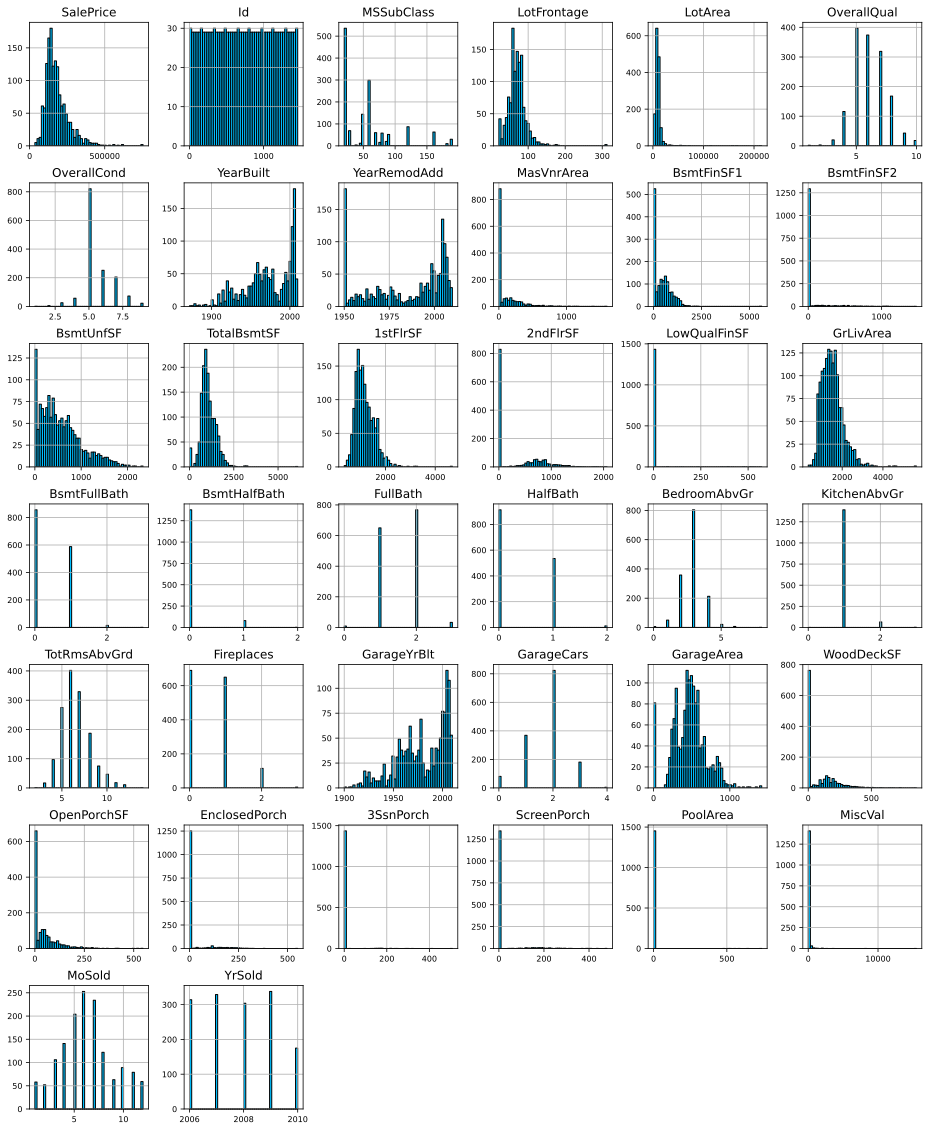

In [9]:
# Dando uma olhada na distribuição destas variáveis 

fig_ = df_num.hist(figsize=(16, 20), bins=50, color="deepskyblue",
                           edgecolor="black", xlabelsize=8, ylabelsize=8)

Olhando as distribuições, é possível perceber que há variáveis que variam pouco em seu valor. Pouca variação nos dados leva a pouco efeito dentro de um modelo e, por isso, irei remover todas as variáveis onde 80% dos dados sejam constantes.

In [10]:
sel = VarianceThreshold(threshold=0.2) 
sel.fit(df_num.iloc[:, :-1])

print(f"Variáveis mantidas: {sum(sel.get_support())}")
print(f"\nVariáveis quase constantes: {len(df_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

quasi_constant_features_list = [x for x in df_num.iloc[:, :-1].columns if x not in df_num.iloc[:, :-1].columns[sel.get_support()]]

print(f"\nVariáveis para dropar: {quasi_constant_features_list}")


Variáveis mantidas: 35

Variáveis quase constantes: 2

Variáveis para dropar: ['BsmtHalfBath', 'KitchenAbvGr']


In [11]:
df_num.drop(quasi_constant_features_list, axis=1, inplace=True)

In [12]:
total = df_num.isnull().sum().sort_values(ascending=False)

percent = (df_num.isnull().sum()/df_num.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
missing_data.head(5)

Total   Percent
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
MasVnrArea        8  0.005479
OpenPorchSF       0  0.000000
BedroomAbvGr      0  0.000000

Irei fazer o input destas três variáveis da forma mais simples, pela média da coluna.

In [13]:
df_num_input = df_num.copy()

In [14]:
df_num_input = df_num_input.fillna(df_num['LotFrontage'].mean())
df_num_input = df_num_input.fillna(df_num['GarageYrBlt'].mean())
df_num_input = df_num_input.fillna(df_num['MasVnrArea'].mean())

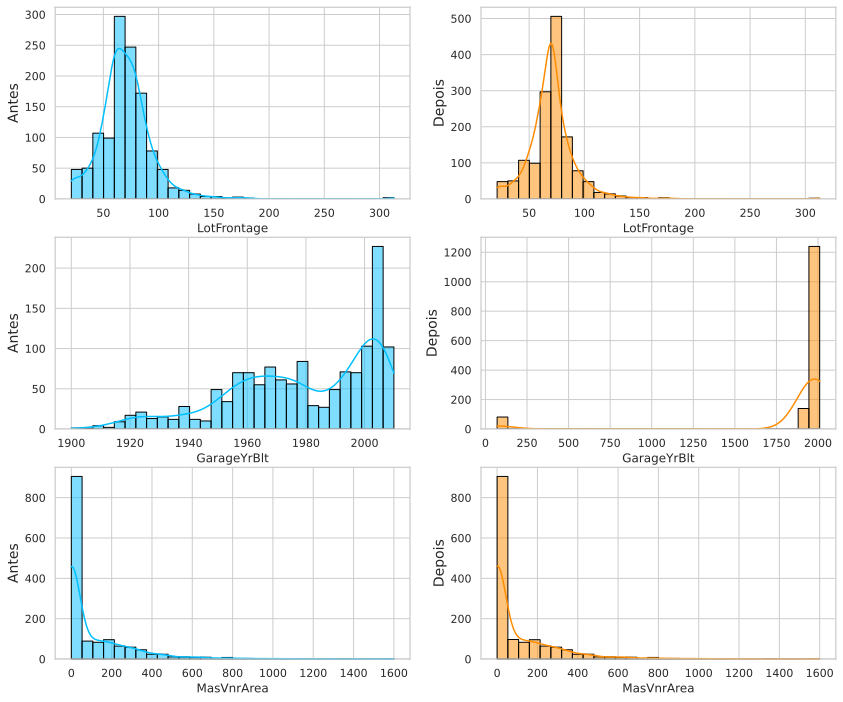

In [15]:
# Agora vamos olhar como as variáveis mudaram antes e depois do input dos dados

sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2)


for feature, fig_pos in zip(["LotFrontage", "GarageYrBlt", "MasVnrArea"], [0, 1, 2]):

    """Distribuição antes e depois de input"""

    # antes
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_num[feature],
                     kde=True, bins=30, color="deepskyblue", edgecolor="black")
    p.set_ylabel(f"Antes", fontsize=14)

    # depois
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_num_input[feature],
                     kde=True, bins=30, color="darkorange", edgecolor="black")
    q.set_ylabel(f"Depois", fontsize=14)

Olhando as mudanças, irei remover GarageYrBlt e manter as outras duas 

In [16]:
df_num = df_num.fillna(df_num['LotFrontage'].mean())
df_num = df_num.fillna(df_num['MasVnrArea'].mean())

In [17]:
df_num.isnull().sum().max() # não temos mais missing values nas variáveis numéricas

0

## Variáveis categóricas

In [18]:
df_cat = [
    i for i in df.columns if df.dtypes[i] == "object"]
df_cat.append("SalePrice")

df_cat = df[df_cat]


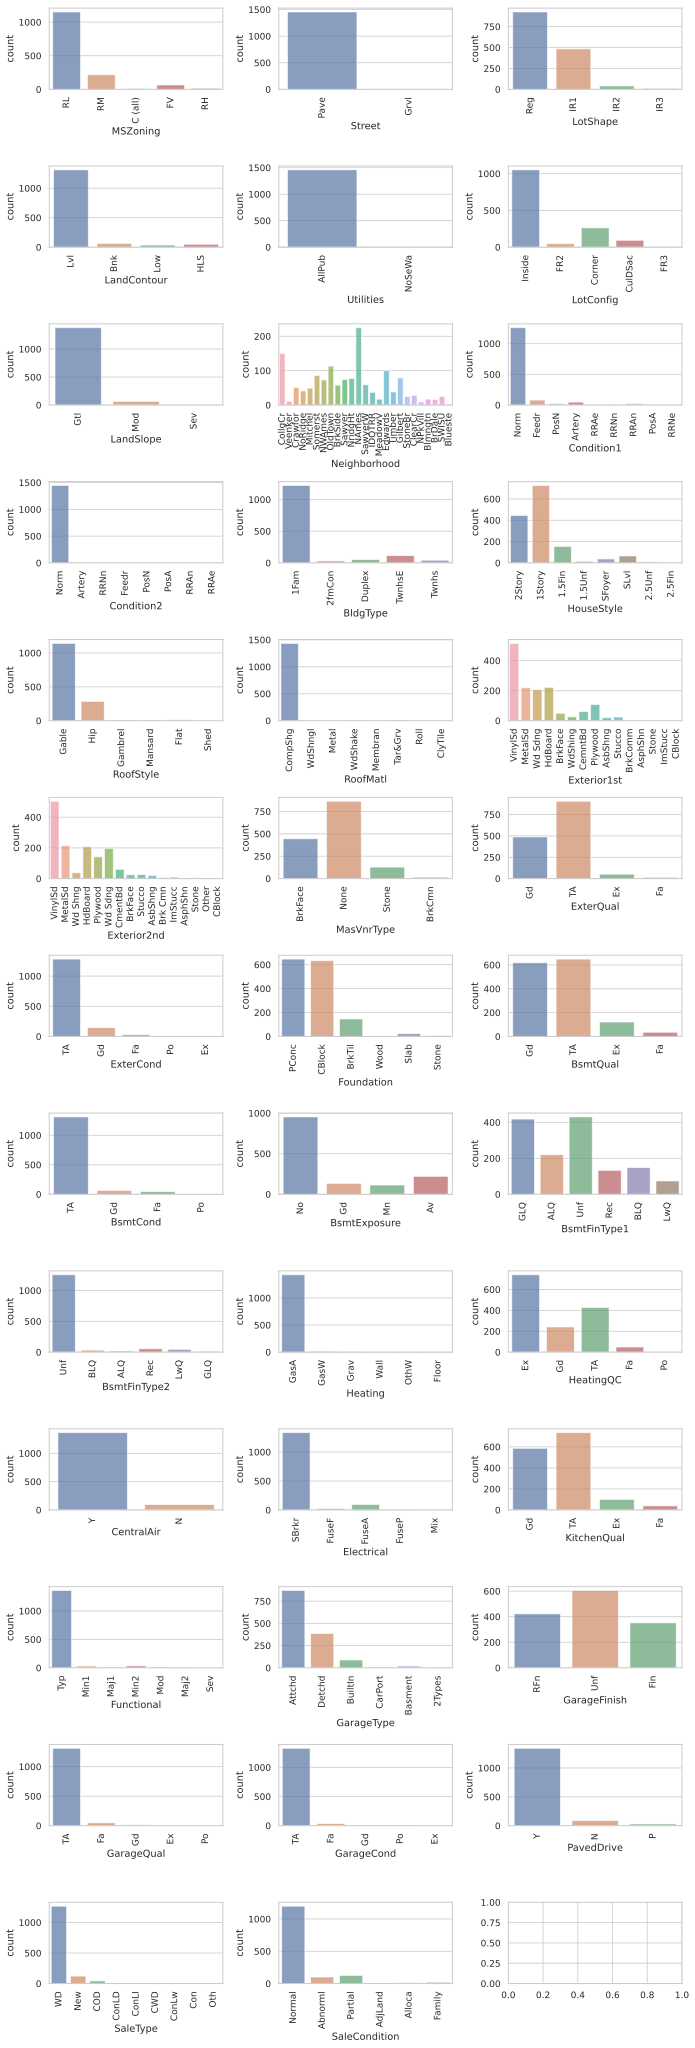

In [19]:
# Assim como nas variáveis numéricas, irei olhar a distribuição para saber se há variáveis muito constantes que podemos dropar por não terem efeito 

fig, axes = plt.subplots(round(len(df_cat.columns) / 3), 3, figsize=(12, 35))

for i, ax in enumerate(fig.axes):
    # plot barplot of each feature
    if i < len(df_cat.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=df_cat.columns[i], alpha=0.7, data=df_cat, ax=ax)

fig.tight_layout()

In [20]:
# Há variáveis claramente dominadas por apenas um valor. Como variáveis muito constantes não tem efeito no modelo, irei removê-las. São elas:

cols_to_drop = [
     'MSZoning',           
    'Street',
    'LandContour',
    'Utilities',
    'LandSlope',
    'Condition1',
    'Condition2',
    'RoofMatl',
    'BsmtCond',
    'BsmtFinType2',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageQual',
    'GarageCond',
    'PavedDrive', 
    'SaleType'
]

df_cat = df_cat.drop(cols_to_drop, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


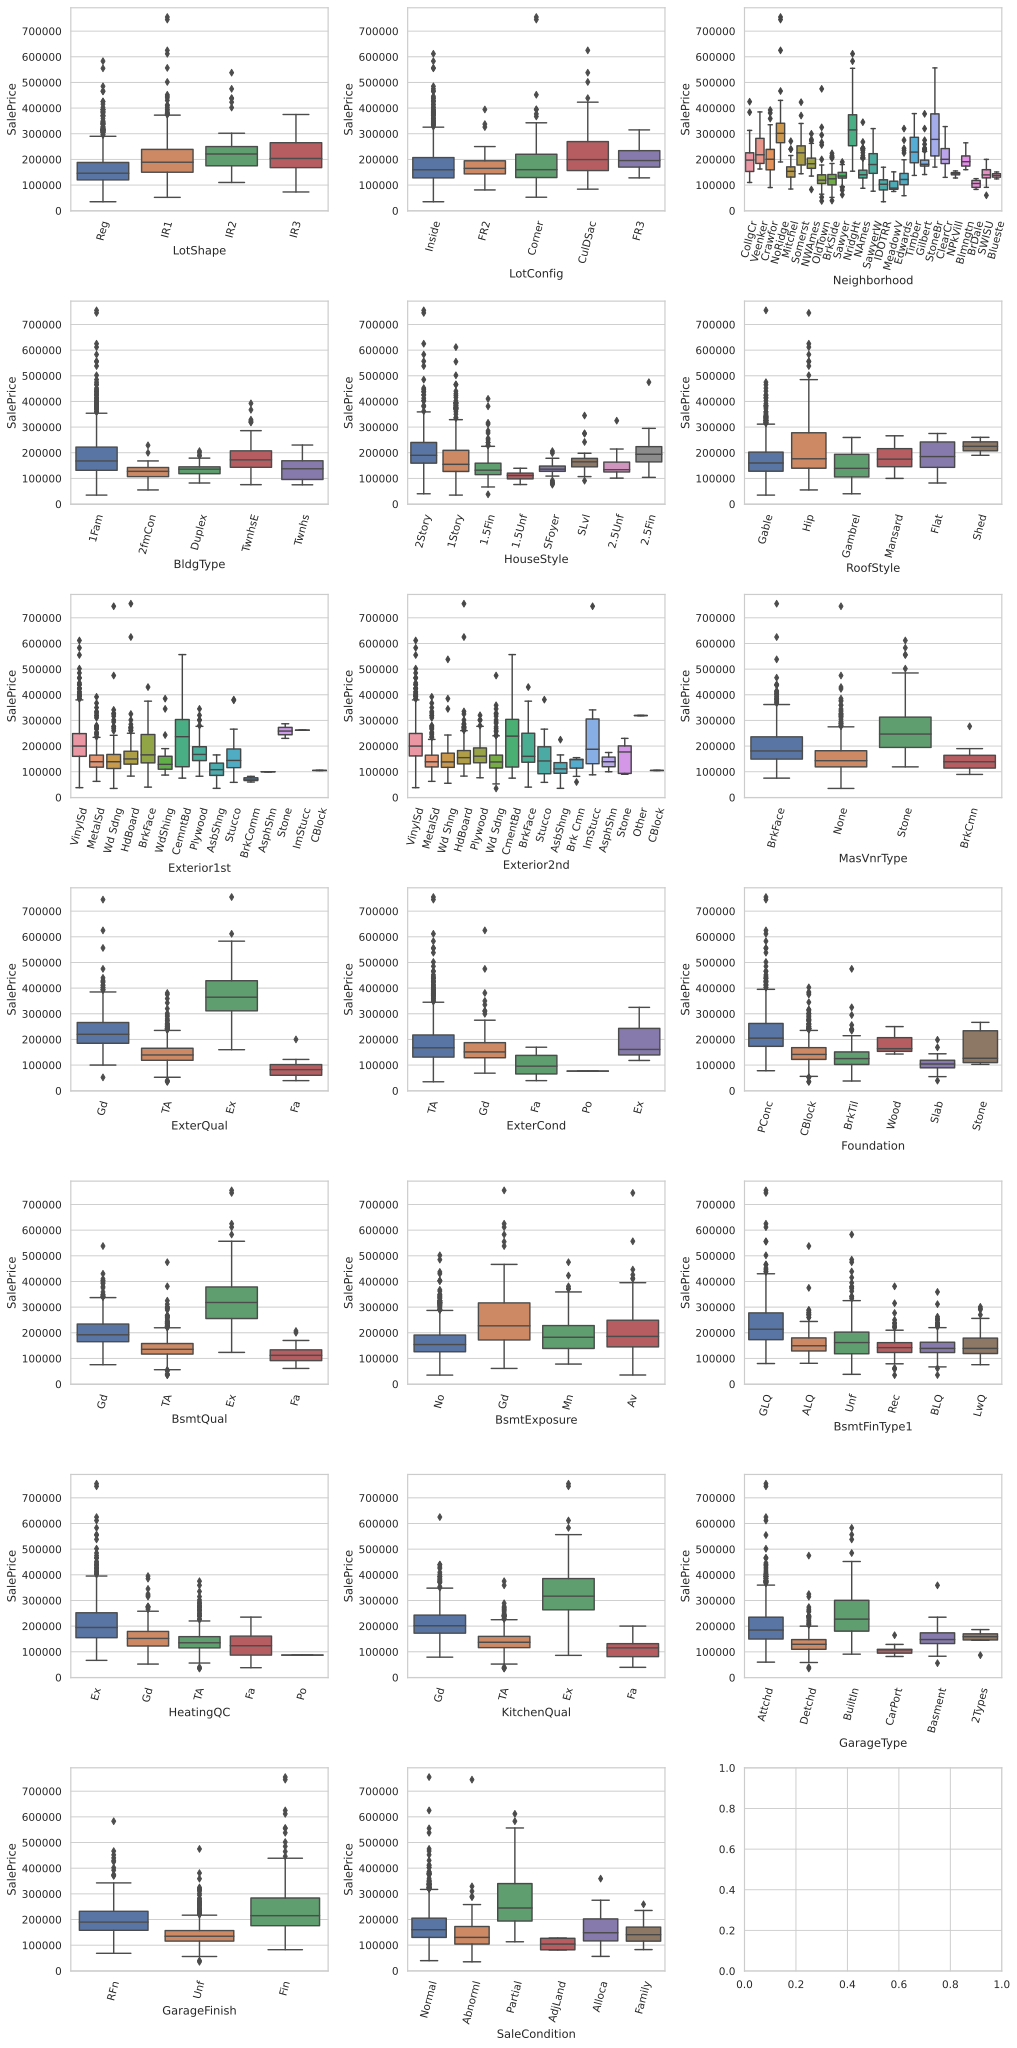

In [21]:
# Agora, por meio de box plots, podemos olhar a distribuição de cada variável em relação a nossa variável dependente 

fig, axes = plt.subplots(
    round(len(df_cat.columns)/3), 3, figsize=(15, 30))

for i, ax in enumerate(fig.axes):
    
    if i < len(df_cat.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
        sns.boxplot(
            x=df_cat.columns[i], y="SalePrice", data=df_cat, ax=ax)

fig.tight_layout()

É notável que algumas variáveis possuem distribuições muito parecidas de SalePrice. Por isso, é interessante olharmos se elas são muito co-dependentes e, caso sim, podemos remover uma do dataset.

Especificamente, estes pares se paracem:

* "Exterior1st" e "Exterior2nd"
* "ExterQual" e "MasVnrType"
* "BsmtQual" e "BsmtExposure"

In [22]:
# O código para realizar esse tipo de teste foi pego do kaggle https://www.kaggle.com/code/harvindarjunrai

sns.set(rc={"figure.figsize": (10, 7)})

X = ["Exterior1st", "ExterQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtExposure"]

# Parameters for Chi-squared test (5% significance level)
prob = 0.95
alpha = 1.0 - prob

for i, j in zip(X, Y):

    # Contingency table
    cont = df_cat[[i, j]].pivot_table(
        index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(df_cat)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  # Replace NaN with 0 in the contingency table
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    # Performing Chi-sq test
    CrosstabResult = pd.crosstab(
        index=df_cat[i], columns=df_cat[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    # P-Value is the Probability of H0 being True
    print(f"P-Value of the ChiSq Test bewteen {i} and {j} is: {ChiSqResult[1]}\n")
    print('significance=%.3f, p=%.3f' % (alpha, ChiSqResult[1]))
    if ChiSqResult[1] <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')



P-Value of the ChiSq Test bewteen Exterior1st and Exterior2nd is: 0.0

significance=0.050, p=0.000
Dependent (reject H0)
P-Value of the ChiSq Test bewteen ExterQual and MasVnrType is: 1.0187554679218715e-54

significance=0.050, p=0.000
Dependent (reject H0)
P-Value of the ChiSq Test bewteen BsmtQual and BsmtExposure is: 3.879215036512606e-32

significance=0.050, p=0.000
Dependent (reject H0)


Como há co-dependência destas variáveis, uma de cada par pode ser dropada

In [23]:
df_cat = df_cat.drop(Y, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [24]:
# Agora vamos olhar os missing values 

total = df_cat.isnull().sum().sort_values(ascending=False)

percent = (df_cat.isnull().sum()/df_cat.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head(5)

Total   Percent
GarageFinish     81  0.055479
GarageType       81  0.055479
BsmtFinType1     37  0.025342
BsmtQual         37  0.025342
LotShape          0  0.000000

In [25]:
# Esse método de input também foi pego do kaggle mencionado acima 

categ_fill_null = {"GarageType": df_cat["GarageType"].mode().iloc[0],
                   "GarageFinish": df_cat["GarageFinish"].mode().iloc[0],
                   "BsmtQual": df_cat["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_cat["BsmtFinType1"].mode().iloc[0]}

df_cat = df_cat.fillna(value=categ_fill_null)

In [26]:
df_cat.isnull().sum().max() # Não temos mais missing values nas variáveis categóricas

0

Agora precisamos transformar as variáveis categóricas em dummies para poder colocá-las no modelo

In [27]:
df_cat = df_cat.drop(["SalePrice"], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [28]:
df_dum = pd.get_dummies(df_cat, drop_first=True)

In [29]:
df_dum

LotShape_IR2  LotShape_IR3  LotShape_Reg  LotConfig_CulDSac  \
0                0             0             1                  0   
1                0             0             1                  0   
2                0             0             0                  0   
3                0             0             0                  0   
4                0             0             0                  0   
...            ...           ...           ...                ...   
1455             0             0             1                  0   
1456             0             0             1                  0   
1457             0             0             1                  0   
1458             0             0             1                  0   
1459             0             0             1                  0   

      LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  Neighborhood_Blueste  \
0                 0              0                 1                     0   
1                 1              0                 0                     0   
2                 0              0                 1                     0   
3                 0              0                 0                     0   
4                 1              0                 0                     0   
...             ...            ...               ...                   ...   
1455              0              0                 1                     0   
1456              0              0                 1                     0   
1457              0              0                 1                     0   
1458              0              0                 1                     0   
1459              0              0                 1                     0   

      Neighborhood_BrDale  Neighborhood_BrkSide  ...  GarageType_BuiltIn  \
0                       0                     0  ...                   0   
1                       0                     0  ...                   0   
2                       0                     0  ...                   0   
3                       0                     0  ...                   0   
4                       0                     0  ...                   0   
...                   ...                   ...  ...                 ...   
1455                    0                     0  ...                   0   
1456                    0                     0  ...                   0   
1457                    0                     0  ...                   0   
1458                    0                     0  ...                   0   
1459                    0                     0  ...                   0   

      GarageType_CarPort  GarageType_Detchd  GarageFinish_RFn  \
0                      0                  0                 1   
1                      0                  0                 1   
2                      0                  0                 1   
3                      0                  1                 0   
4                      0                  0                 1   
...                  ...                ...               ...   
1455                   0                  0                 1   
1456                   0                  0                 0   
1457                   0                  0                 1   
1458                   0                  0                 0   
1459                   0                  0                 0   

      GarageFinish_Unf  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                    0                      0                     0   
1                    0                      0                     0   
2                    0                      0                     0   
3                    1                      0                     0   
4                    0                      0                     0   
...                ...                    ...                   ...   
1455                 0                      0    

## Criando variáveis

Há duas variáveis que trazem informações sobre o ano que a casa foi construída e o ano que foi reformada. Entretanto, parece ser mais informativo termos a informação de quanto tempo faz que essas coisas aconteceram do que o ano que aconteceram. Então, ireia fazer essa tranformação

In [30]:
# Primeiro precisamos juntar as variáveis dummies e as numéricas de volta

df_n = pd.concat([df_num, df_dum], axis = 1)
print(f"DF: {df_n.shape}")

DF: (1460, 136)


In [31]:
df_n["AgeSinceConst"] = (df_n["YearBuilt"].max() - df_n["YearBuilt"])
df_n = df_n.drop(["YearBuilt"], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [32]:
df_n["AgeSinceRemod"] = (df_n["YearRemodAdd"].max() - df_n["YearRemodAdd"])
df_n = df_n.drop(["YearRemodAdd"], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


## Train test split nos dados

In [33]:
df_n = df_n.drop('Id', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [34]:
train, test = train_test_split(df_n, test_size=0.3, random_state = 1)

## Olhando a variável dependente

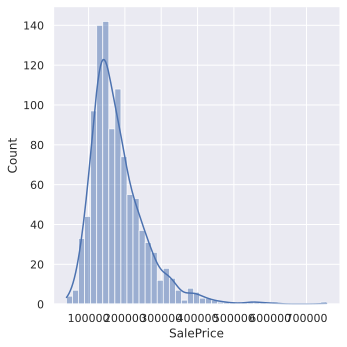

In [35]:
sns.displot(train['SalePrice'], kde=True);

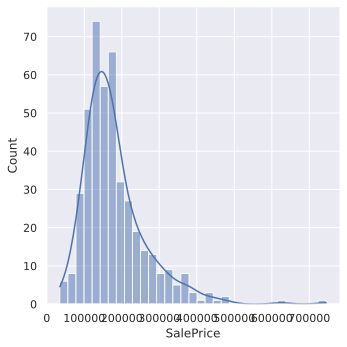

In [36]:
sns.displot(test['SalePrice'], kde=True);

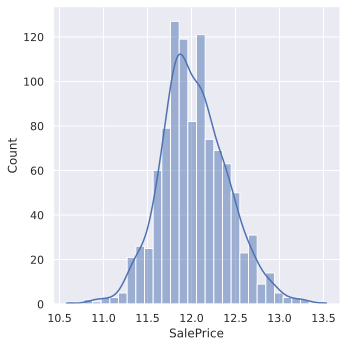

In [37]:
sns.displot(np.log1p(train['SalePrice']), kde=True);

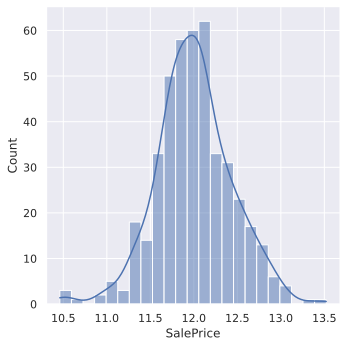

In [38]:
sns.displot(np.log1p(test['SalePrice']), kde=True);

É possível perceber que a variável dependente tende para a esquerda. Para tornar sua distribuição normal, irei usar o log.

In [39]:
train['SalePrice'] = np.log1p(train['SalePrice'])
test['SalePrice'] = np.log1p(test['SalePrice'])

## Correlation Matrix

In [40]:
corr_matrix = train.corr().sort_values(
    by = "SalePrice",  ascending=False, key = abs)
corr_matrix.head(10)

SalePrice  MSSubClass  LotFrontage   LotArea  OverallQual  \
SalePrice          1.000000   -0.093480     0.318156  0.269070     0.804035   
OverallQual        0.804035    0.037913     0.239457  0.113560     1.000000   
GrLivArea          0.693735    0.058138     0.350559  0.278004     0.598385   
GarageCars         0.680259   -0.054044     0.280197  0.156982     0.581545   
GarageArea         0.643901   -0.117231     0.338159  0.182415     0.541389   
FullBath           0.611537    0.125495     0.170479  0.134447     0.562303   
TotalBsmtSF        0.592936   -0.243096     0.371004  0.269160     0.526140   
ExterQual_TA      -0.588897   -0.067985    -0.123446 -0.019599    -0.638127   
1stFlrSF           0.586409   -0.265793     0.421516  0.311075     0.462571   
GarageFinish_Unf  -0.559765    0.046513    -0.236872 -0.084209    -0.512063   

                  OverallCond  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
SalePrice           -0.066027    0.432571    0.366188    0.002978   0.218008   
OverallQual         -0.113034    0.425914    0.236122   -0.061214   0.311266   
GrLivArea           -0.095342    0.392901    0.231336   -0.026904   0.224774   
GarageCars          -0.208628    0.370336    0.226537   -0.046619   0.208297   
GarageArea          -0.184285    0.390140    0.316417   -0.021788   0.172652   
FullBath            -0.247570    0.291096    0.102262   -0.119473   0.272438   
TotalBsmtSF         -0.182606    0.387219    0.543963    0.118473   0.402793   
ExterQual_TA         0.200865   -0.266009   -0.137986    0.081234  -0.266686   
1stFlrSF            -0.153199    0.369777    0.459641    0.105827   0.297402   
GarageFinish_Unf     0.229698   -0.285009   -0.233680    0.018388  -0.133172   

                  ...  GarageType_Detchd  GarageFinish_RFn  GarageFinish_Unf  \
SalePrice         ...          -0.388296          0.232743         -0.559765   
OverallQual       ...          -0.325682          0.212133         -0.512063   
GrLivArea         ...          -0.213304          0.061485         -0.300139   
GarageCars        ...          -0.163182          0.205035         -0.468751   
GarageArea        ...          -0.141283          0.232154         -0.428303   
FullBath          ...          -0.300496          0.216216         -0.440858   
TotalBsmtSF       ...          -0.309600          0.151826         -0.365094   
ExterQual_TA      ...           0.287264         -0.241443          0.502316   
1stFlrSF          ...          -0.303681          0.109581         -0.317897   
GarageFinish_Unf  ...           0.556622         -0.612487          1.000000   

                  SaleCondition_AdjLand  SaleCondition_Alloca  \
SalePrice                     -0.057542             -0.001620   
OverallQual                   -0.036826             -0.041103   
GrLivArea                     -0.038034              0.040631   
GarageCars                    -0.108423              0.028389   
GarageArea                    -0.100421             -0.009566   
FullBath                       0.035945              0.030797   
TotalBsmtSF                   -0.058123             -0.053870   
ExterQual_TA                   0.035219              0.047855   
1stFlrSF                      -0.011851              0.049135   
GarageFinish_Unf               0.048368              0.074730   

                  SaleCondition_Family  SaleCondition_Normal  \
SalePrice                    -0.046956             -0.122841   
OverallQual                  -0.017457             -0.151060   
GrLivArea                    -0.005037             -0.106393   
GarageCars                    0.016485             -0.139635   
GarageArea                    0.005757             -0.151301   
FullBath                      0.038534             -0.171229   
TotalBsmtSF                   0.025166             -0.176096   
ExterQual_TA                  0.046967              0.148439   
1stFlrSF                      0.032487             -0.184729   
GarageFinish_Unf              

Aqui é possível perceber que 'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars' se destacam na correlação com a nossa variável dependente. Isso é importante na decisão das variáveis a serem adicionadas no modelo.

## Outlier detection

In [41]:
n = 2

upper_limit = train['SalePrice'].mean() + n*train['SalePrice'].std()
lower_limit = train['SalePrice'].mean() - n*train['SalePrice'].std()

print("Highest allowed", upper_limit)
print("Lowest allowed", lower_limit)

Highest allowed 12.798646944221764
Lowest allowed 11.26664340018648


In [42]:
train_trimmed = train[
    ( train['SalePrice'] < upper_limit ) & 

    ( train['SalePrice'] > lower_limit )
    ]

In [43]:
train.shape

(1022, 135)

In [44]:
train_trimmed.shape #removeu 49 observações

(975, 135)

In [45]:
train_censored = pd.DataFrame()
train_censored['SalePrice'] =  np.where(
    train['SalePrice'] > upper_limit,
        upper_limit,
        np.where(
            train['SalePrice'] < lower_limit, 
            lower_limit,                   
            train['SalePrice']                
            )
        )

In [46]:
train_censored.shape

(1022, 1)

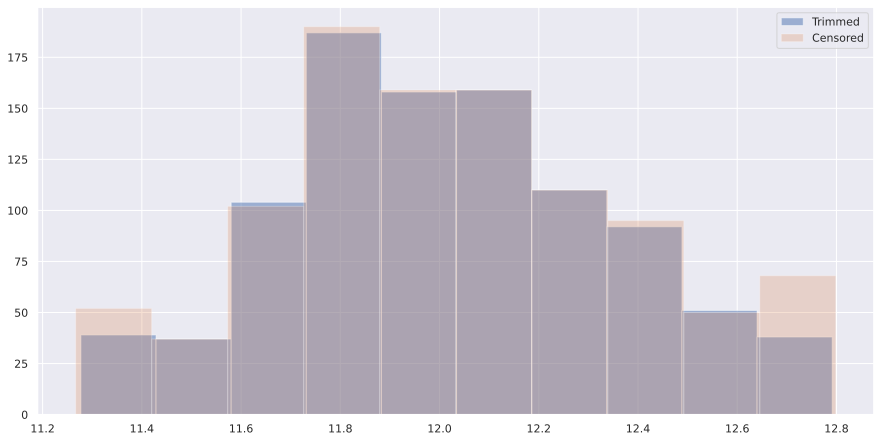

In [47]:
plt.figure(figsize=(15, 7.5))
#plt.hist(train['SalePrice'], alpha=1, label='Original Data')
plt.hist(train_trimmed['SalePrice'], alpha=0.5, label='Trimmed')
plt.hist(train_censored['SalePrice'], alpha=0.25, label='Censored')

plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

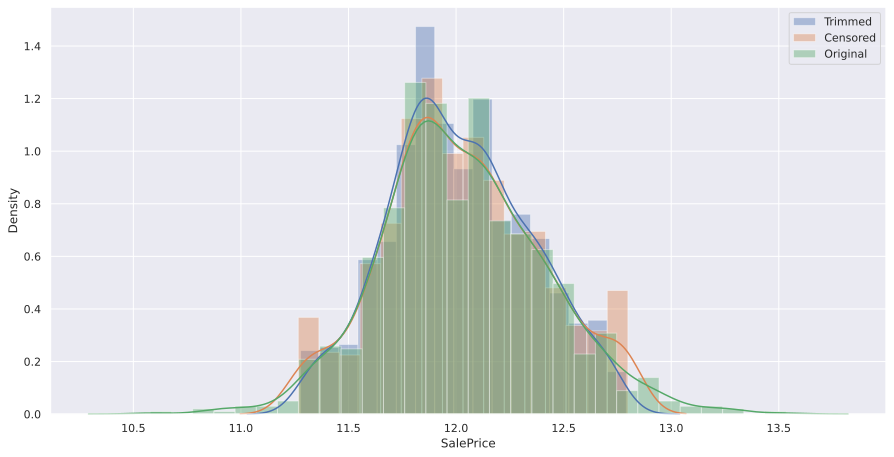

In [48]:
plt.figure(figsize=(15, 7.5))
sns.distplot(train_trimmed['SalePrice'], kde = True, label='Trimmed');
sns.distplot(train_censored['SalePrice'], kde = True, label='Censored');
sns.distplot(train['SalePrice'], kde = True, label='Original')

plt.legend(loc='upper right')
plt.show()

Optei por aplicar a regra de trimming por ter retirado algumas observações que estavam muito na ponta da distribuição



In [49]:
train_trimmed

SalePrice  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
632   11.320566          20    85.000000    11900            7            5   
208   12.531776          60    70.049958    14364            7            5   
83    11.748005          20    80.000000     8892            5            5   
1174  12.384223          70    80.000000    16560            6            8   
895   11.849405          60    71.000000     7056            6            5   
...         ...         ...          ...      ...          ...          ...   
715   12.013707          20    78.000000    10140            6            5   
905   11.759793          20    80.000000     9920            5            5   
1096  11.751950          70    60.000000     6882            6            7   
235   11.402005         160    21.000000     1680            6            3   
1061  11.302217          30   120.000000    18000            3            4   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  GarageType_Detchd  \
632        209.0         822           0        564  ...                  0   
208        128.0        1065           0         92  ...                  0   
83          66.0           0           0       1065  ...                  1   
1174         0.0         503           0        449  ...                  1   
895        415.0         400           0        380  ...                  0   
...          ...         ...         ...        ...  ...                ...   
715        174.0           0           0       1064  ...                  0   
905        110.0         354         290        412  ...                  0   
1096         0.0           0           0        684  ...                  0   
235        604.0         358           0        125  ...                  1   
1061         0.0           0           0        894  ...                  1   

      GarageFinish_RFn  GarageFinish_Unf  SaleCondition_AdjLand  \
632                  0                 0                      0   
208                  0                 0                      0   
83                   0                 1                      0   
1174                 0                 1                      0   
895                  1                 0                      0   
...                ...               ...                    ...   
715                  1                 0                      0   
905                  1                 0                      0   
1096                 0                 1                      0   
235                  0                 1                      0   
1061                 1                 0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
632                      0                     1                     0   
208                      0                     0                     1   
83                       0                     0                     1   
1174                     0                     0                     1   
895                      0                     0                     1   
...                    ...                   ...                   ...   
715                      0                     0                     1   
905                      0                     0                     1   
1096                     0                     0                     1   
235                      0                     0                     1   
1061                     0                     0                     1   

      SaleCondition_Partial  AgeSinceConst  AgeSinceRemod  
632                       0             33             33  
208                       0             22             21  
83                        0             50             50  
1174                      0             78             60  
895                       0             47             47  
...                     ...            ...            

In [50]:
corr_matrix = train_trimmed.corr().sort_values(
    by = "SalePrice",  ascending=False, key = abs)
corr_matrix.head(10)

SalePrice  MSSubClass  LotFrontage   LotArea  OverallQual  \
SalePrice          1.000000   -0.079544     0.297758  0.261926     0.765242   
OverallQual        0.765242    0.068494     0.196234  0.083181     1.000000   
GrLivArea          0.652940    0.076908     0.345469  0.298294     0.546127   
GarageCars         0.631148   -0.031611     0.258319  0.154039     0.518169   
FullBath           0.603836    0.136811     0.149749  0.119613     0.544895   
ExterQual_TA      -0.602824   -0.082463    -0.102374 -0.017141    -0.641741   
GarageArea         0.588006   -0.098682     0.322014  0.196633     0.470661   
ExterQual_Gd       0.565698    0.069173     0.055267 -0.004558     0.584266   
GarageFinish_Unf  -0.559319    0.035448    -0.221174 -0.063525    -0.495734   
AgeSinceConst     -0.555052   -0.045496    -0.100923  0.007903    -0.519014   

                  OverallCond  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
SalePrice           -0.103153    0.334670    0.288469   -0.002923   0.214769   
OverallQual         -0.141659    0.349202    0.154586   -0.069117   0.306059   
GrLivArea           -0.126640    0.303910    0.183064   -0.026485   0.206174   
GarageCars          -0.243328    0.300903    0.161430   -0.045245   0.193314   
FullBath            -0.283695    0.241421    0.059342   -0.125381   0.272561   
ExterQual_TA         0.204201   -0.219349   -0.091613    0.076064  -0.270700   
GarageArea          -0.216105    0.316116    0.263666   -0.013711   0.156801   
ExterQual_Gd        -0.202342    0.171001    0.059425   -0.074602   0.242472   
GarageFinish_Unf     0.240175   -0.258584   -0.195287    0.022165  -0.127460   
AgeSinceConst        0.431220   -0.287606   -0.220009    0.062802  -0.128101   

                  ...  GarageType_Detchd  GarageFinish_RFn  GarageFinish_Unf  \
SalePrice         ...          -0.405890          0.262486         -0.559319   
OverallQual       ...          -0.323482          0.235122         -0.495734   
GrLivArea         ...          -0.200777          0.070825         -0.274192   
GarageCars        ...          -0.147265          0.213703         -0.442904   
FullBath          ...          -0.289458          0.219449         -0.426703   
ExterQual_TA      ...           0.272961         -0.254440          0.490213   
GarageArea        ...          -0.121668          0.243049         -0.404039   
ExterQual_Gd      ...          -0.267917          0.271479         -0.474785   
GarageFinish_Unf  ...           0.554142         -0.626342          1.000000   
AgeSinceConst     ...           0.483393         -0.333466          0.601887   

                  SaleCondition_AdjLand  SaleCondition_Alloca  \
SalePrice                     -0.066742              0.002584   
OverallQual                   -0.039270             -0.042205   
GrLivArea                     -0.039802              0.048364   
GarageCars                    -0.114878              0.032963   
FullBath                       0.038393              0.034061   
ExterQual_TA                   0.034917              0.046531   
GarageArea                    -0.107176             -0.007417   
ExterQual_Gd                  -0.033250             -0.042865   
GarageFinish_Unf               0.049071              0.075637   
AgeSinceConst                  0.009299              0.007940   

                  SaleCondition_Family  SaleCondition_Normal  \
SalePrice                    -0.050101             -0.041188   
OverallQual                  -0.014436             -0.085902   
GrLivArea                    -0.000287             -0.072248   
GarageCars                    0.021165             -0.088508   
FullBath                      0.042874             -0.150889   
ExterQual_TA                  0.044554              0.111940   
GarageArea                    0.010262             -0.091235   
ExterQual_Gd                 -0.039250             -0.086990   
GarageFinish_Unf              0.001543              0.064038   
AgeSinceConst                 

É possível notar que, após removermos os outliers pelo método de trimming, a matriz de correlação sofre alterações. Por exemplo, GarageArea perde espaço para FullBath e ExterQual_TA.

# Parte II: Escolhendo as variáveis para treinar o modelo

Primeiro, irei selecionar um subconjunto de features baseada na correlação das variáveis com SalePrice.

In [51]:
# Agora vamos pegar um subconjunto com as features de maior correlação
# esse código também foi pego do kaggle

data_num_corr = train_trimmed.corr()["SalePrice"][:-1]

# Variáveis correlacionadas (r2 > 0.5)
high_features_list = data_num_corr[abs(data_num_corr) >= 0.5].sort_values(ascending=False)
print(f"{len(high_features_list)} variáveis fortemente correlacionadas à SalePrice:\n{high_features_list}\n")

# Variáveis correlacionadas (0.3 < r2 < 0.5)
low_features_list = data_num_corr[(abs(data_num_corr) < 0.5) & (abs(data_num_corr) >= 0.3)].sort_values(ascending=False)
print(f"{len(low_features_list)} variáveis mediamente correlacionadas à SalePrice:\n{low_features_list}")

15 variáveis fortemente correlacionadas à SalePrice:
SalePrice           1.000000
OverallQual         0.765242
GrLivArea           0.652940
GarageCars          0.631148
FullBath            0.603836
GarageArea          0.588006
ExterQual_Gd        0.565698
TotalBsmtSF         0.522193
Foundation_PConc    0.518911
1stFlrSF            0.507021
BsmtQual_TA        -0.541602
KitchenQual_TA     -0.545076
AgeSinceConst      -0.555052
GarageFinish_Unf   -0.559319
ExterQual_TA       -0.602824
Name: SalePrice, dtype: float64

15 variáveis mediamente correlacionadas à SalePrice:
TotRmsAbvGrd           0.472853
KitchenQual_Gd         0.467660
BsmtQual_Gd            0.448130
Fireplaces             0.439166
BsmtFinType1_GLQ       0.400416
Exterior1st_VinylSd    0.340144
MasVnrArea             0.334670
2ndFlrSF               0.323748
GarageType_Attchd      0.317285
OpenPorchSF            0.309191
GarageYrBlt            0.301843
LotShape_Reg          -0.309337
Foundation_CBlock     -0.337382
HeatingQC_

In [52]:
strong_features = data_num_corr[abs(data_num_corr) >= 0.5].index.tolist()
low_features = data_num_corr[(abs(data_num_corr) >= 0.3) & (abs(data_num_corr) < 0.5)].index.tolist()
selected_features = strong_features[:-1] + low_features

In [53]:
selected_features

['SalePrice',
 'OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'GarageCars',
 'GarageArea',
 'ExterQual_Gd',
 'ExterQual_TA',
 'Foundation_PConc',
 'BsmtQual_TA',
 'KitchenQual_TA',
 'GarageFinish_Unf',
 'MasVnrArea',
 '2ndFlrSF',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'OpenPorchSF',
 'LotShape_Reg',
 'Exterior1st_VinylSd',
 'Foundation_CBlock',
 'BsmtQual_Gd',
 'BsmtFinType1_GLQ',
 'HeatingQC_TA',
 'KitchenQual_Gd',
 'GarageType_Attchd',
 'GarageType_Detchd']

In [54]:
corr_matrix = train_trimmed[selected_features].corr().sort_values(
    by = "SalePrice",  ascending=False, key = abs)
corr_matrix.head(10)

SalePrice  OverallQual  TotalBsmtSF  1stFlrSF  GrLivArea  \
SalePrice          1.000000     0.765242     0.522193  0.507021   0.652940   
OverallQual        0.765242     1.000000     0.447859  0.369176   0.546127   
GrLivArea          0.652940     0.546127     0.392906  0.529928   1.000000   
GarageCars         0.631148     0.518169     0.349583  0.364132   0.404104   
FullBath           0.603836     0.544895     0.291052  0.345608   0.597319   
ExterQual_TA      -0.602824    -0.641741    -0.342623 -0.235157  -0.346735   
GarageArea         0.588006     0.470661     0.432695  0.439012   0.416010   
ExterQual_Gd       0.565698     0.584266     0.280458  0.182351   0.289482   
GarageFinish_Unf  -0.559319    -0.495734    -0.327293 -0.279456  -0.274192   
KitchenQual_TA    -0.545076    -0.550811    -0.273059 -0.220708  -0.311830   

                  FullBath  GarageCars  GarageArea  ExterQual_Gd  \
SalePrice         0.603836    0.631148    0.588006      0.565698   
OverallQual       0.544895    0.518169    0.470661      0.584266   
GrLivArea         0.597319    0.404104    0.416010      0.289482   
GarageCars        0.470421    1.000000    0.871480      0.424618   
FullBath          1.000000    0.470421    0.397575      0.442255   
ExterQual_TA     -0.471798   -0.451159   -0.406195     -0.952259   
GarageArea        0.397575    0.871480    1.000000      0.362880   
ExterQual_Gd      0.442255    0.424618    0.362880      1.000000   
GarageFinish_Unf -0.426703   -0.442904   -0.404039     -0.474785   
KitchenQual_TA   -0.412704   -0.373925   -0.331929     -0.628346   

                  ExterQual_TA  ...  OpenPorchSF  LotShape_Reg  \
SalePrice            -0.602824  ...     0.309191     -0.309337   
OverallQual          -0.641741  ...     0.275481     -0.169979   
GrLivArea            -0.346735  ...     0.334865     -0.166017   
GarageCars           -0.451159  ...     0.165746     -0.196596   
FullBath             -0.471798  ...     0.267460     -0.136222   
ExterQual_TA          1.000000  ...    -0.219772      0.173057   
GarageArea           -0.406195  ...     0.199279     -0.178541   
ExterQual_Gd         -0.952259  ...     0.167587     -0.166957   
GarageFinish_Unf      0.490213  ...    -0.182094      0.210431   
KitchenQual_TA        0.645749  ...    -0.187685      0.128262   

                  Exterior1st_VinylSd  Foundation_CBlock  BsmtQual_Gd  \
SalePrice                    0.340144          -0.337382     0.448130   
OverallQual                  0.332391          -0.428715     0.418217   
GrLivArea                    0.098834          -0.245454     0.178350   
GarageCars                   0.323036          -0.302779     0.378159   
FullBath                     0.321020          -0.392988     0.436926   
ExterQual_TA                -0.455324           0.487397    -0.483616   
GarageArea                   0.257297          -0.230435     0.270798   
ExterQual_Gd                 0.465977          -0.469645     0.525142   
GarageFinish_Unf            -0.368085           0.237904    -0.420606   
KitchenQual_TA              -0.373829           0.452871    -0.389313   

                  BsmtFinType1_GLQ  HeatingQC_TA  KitchenQual_Gd  \
SalePrice                 0.400416     -0.338262        0.467660   
OverallQual               0.381896     -0.336398        0.446987   
GrLivArea                 0.133766     -0.163177        0.232349   
GarageCars                0.279267     -0.216852        0.360678   
FullBath                  0.250541     -0.256587        0.389656   
ExterQual_TA             -0.388054      0.406962       -0.588198   
GarageArea                0.270306     -0.138331        0.300002   
ExterQual_Gd              0.361606     -0.395953        0.615329   
GarageFinish_Unf         -0.322649      0.301495       -0.351860   
KitchenQual_TA           -0.350440      0.396040       -0.870662   

                  GarageType_Attchd  GarageType_Detchd  
SalePrice                  0.317285          -0.405890  
OverallQual     

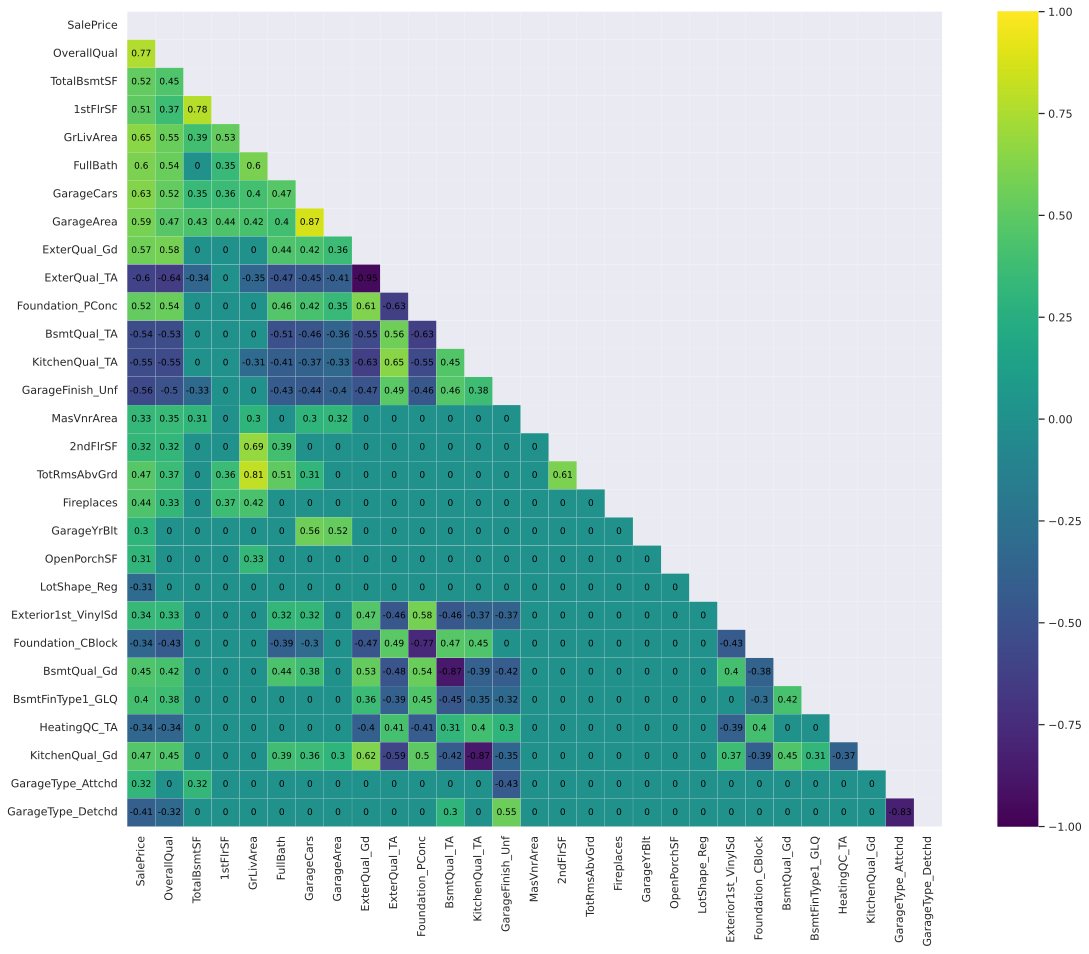

In [55]:
pd.options.display.float_format = "{:,.2f}".format

# Define correlation matrix
corr_matrix = train_trimmed[selected_features].corr()

# Replace any correlation < |0.3| by 0 for a better visibility
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0

# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Choose the color map
cmap = "viridis"

# plot the heatmap
sns.set(rc = {'figure.figsize':(20,15)})
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"}, square=True, cmap=cmap, annot=True)

# Parte III: Modelos e acurácia

In [56]:
train_sub = train_trimmed[selected_features]
test_sub = test[selected_features]

In [57]:
x_train = train_sub.drop(['SalePrice'], 1)
y_train = train_sub['SalePrice']

x_test = test_sub.drop(['SalePrice'], 1)
y_test = test['SalePrice']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [58]:
# irei usar duas métricas de acurácia: mae e mape

from sklearn.metrics import mean_absolute_error as mae

def mape(Y_actual, Y_Predicted):
    mape = (np.mean(np.abs(Y_actual - Y_Predicted)/Y_actual))*100
    return mape


In [59]:
naive_model = y_train.mean()
pred_naive = np.repeat(naive_model, len(y_test))

print('Mape: ', round(mape(np.exp(y_test) , np.exp(pred_naive)), 2))
print('Mae: ', round(mae(np.exp(y_test) , np.exp(pred_naive)), 2))


Mape:  36.07
Mae:  58402.93


LINEAR 

In [60]:
X_lr = sm.add_constant(x_train)

X_lr_test = sm.add_constant(x_test)
linear_reg = sm.OLS(y_train, X_lr )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_lr_test)
print(linear_reg_fit.summary())

print('Mape')
print(round(mape(np.exp(y_test) , np.exp(linear_reg_pred)), 2))

print('Mae')
print(round(mae(np.exp(y_test) , np.exp(linear_reg_pred)), 2))

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     141.4
Date:                Sun, 15 May 2022   Prob (F-statistic):          6.33e-315
Time:                        18:43:17   Log-Likelihood:                 509.03
No. Observations:                 975   AIC:                            -960.1
Df Residuals:                     946   BIC:                            -818.5
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.8576    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


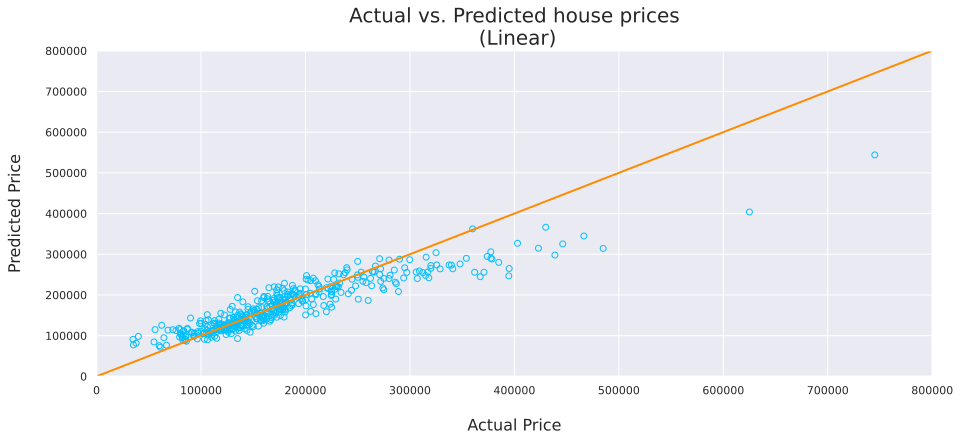

In [61]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted house prices\n (Linear)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(linear_reg_pred),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

RIDGE

In [62]:
ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(x_train, y_train)
ridge_pred = ridge_reg.predict(x_test)

print(round(mape(np.exp(y_test), np.exp(ridge_pred)),2))
print(round(mae(np.exp(y_test), np.exp(ridge_pred)), 2))

13.74
23622.35


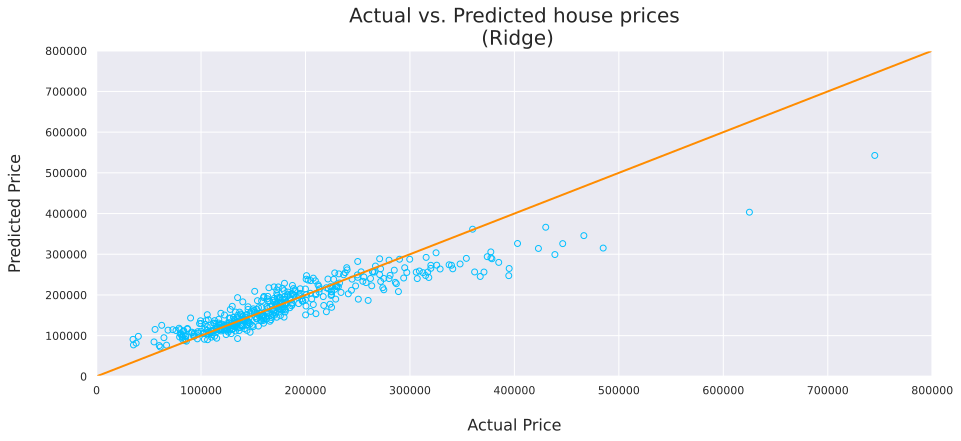

In [63]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted house prices\n (Ridge)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(ridge_pred),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

In [64]:
# Procurando o melhor hiperparâmtero

alphas = np.linspace(0, 10, 100).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
ridge_cv = GridSearchCV(Ridge(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
ridge_cv.fit(x_train, y_train)

# print best params 
print(f"Best hyperparameters: {ridge_cv.best_params_}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best hyperparameters: {'alpha': 10.0}


In [65]:
ridge_reg_h = Ridge(alpha = 10)
ridge_reg_h.fit(x_train, y_train)
ridge_pred_h = ridge_reg_h.predict(x_test)

print(round(mape(np.exp(y_test), np.exp(ridge_pred_h)), 2))
print(round(mae(np.exp(y_test), np.exp(ridge_pred_h)), 2))

13.79
23616.41


LASSO

In [66]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(x_train, y_train)

lasso_pred = model_lasso.predict(x_test)

coef = pd.Series(model_lasso.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 27 variables and eliminated the other 1 variables


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015720623839868608, tolerance: 0.00848991145135695
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03784634269239895, tolerance: 0.00848991145135695
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.104e-01, tolerance: 1.042e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

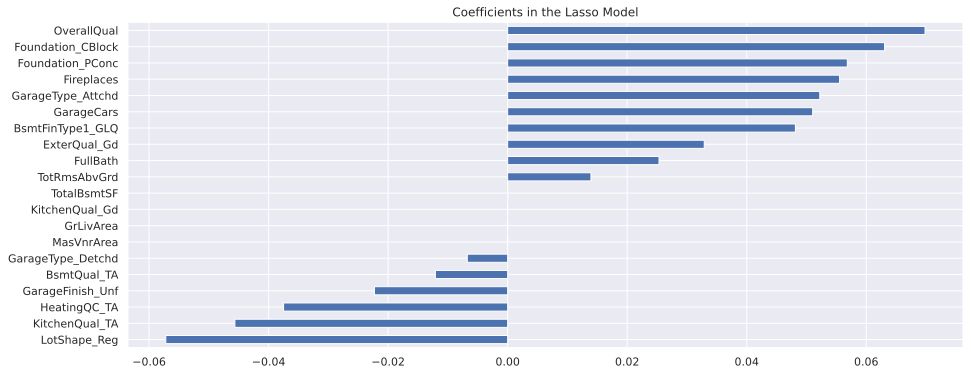

In [67]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.figure(figsize=(15,6))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [68]:
print(round(mape(np.exp(y_test), np.exp(lasso_pred)), 2))
print(round(mae(np.exp(y_test), np.exp(lasso_pred)), 2))

13.8
23588.88


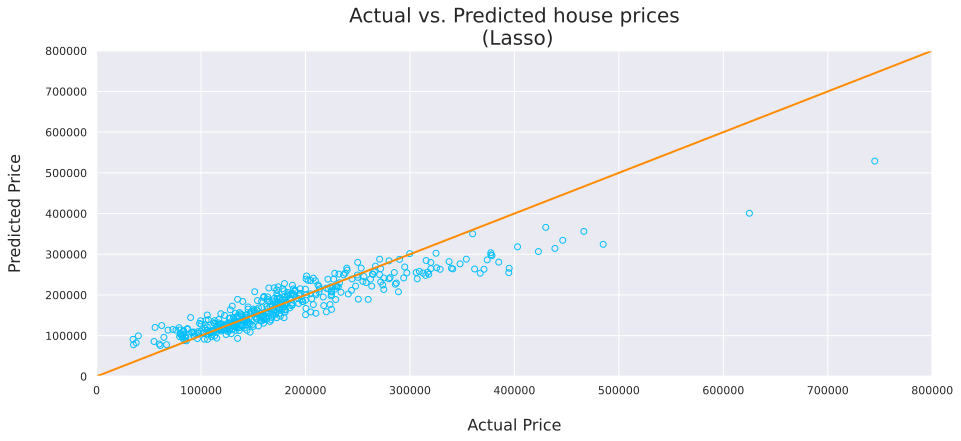

In [69]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted house prices\n (Lasso)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(lasso_pred),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

ELASTIC NET

In [70]:
model_ElasticNet = ElasticNetCV(
    l1_ratio = [.1, .5, .7, .9, .95, .99, 1],
    alphas = [1, 0.1, 0.001, 0.0005],
    fit_intercept = True
).fit(x_train, y_train)

elastic_pred = model_ElasticNet.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009113857150918392, tolerance: 0.00848991145135695
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.47604405957265, tolerance: 0.00848991145135695
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040674106959269096, tolerance: 0.00848991145135695
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

In [71]:
coef = pd.Series(model_ElasticNet.coef_, index = x_train.columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 28 variables and eliminated the other 0 variables


In [72]:
print(round(mape(np.exp(y_test), np.exp(elastic_pred)), 2))
print(round(mae(np.exp(y_test), np.exp(elastic_pred)), 2))

13.75
23608.62


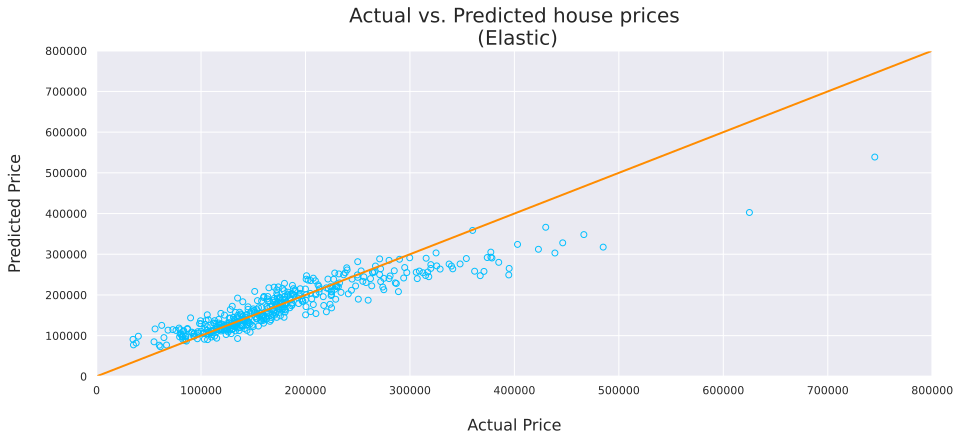

In [73]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted house prices\n (Elastic)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(elastic_pred),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

Há uma redução considerável do modelo naive. Entretanto, não há uma melhora na acurácia do modelo mais simples de regressão linear para as outras regressões. 

# **Exercício 3**

# Exercício 1 com Random Forest

In [74]:
train_sub = train_trimmed[selected_features]
test_sub = test[selected_features]

In [75]:
x_train = train_sub.drop(['SalePrice'], 1)
y_train = train_sub['SalePrice']

x_test = test_sub.drop(['SalePrice'], 1)
y_test = test['SalePrice']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [76]:
parameters = {'max_depth' : [8, 10, 12, 20],
              'n_estimators' : [200, 250, 300],
              'max_features' : [5, 25, 50],
              'min_samples_split' : [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state=42),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 5)
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [8, 10, 12, 20],
                         'max_features': [5, 25, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 250, 300]},
             scoring='neg_mean_squared_error')

In [77]:
grid_search.best_params_

{'max_depth': 12,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [78]:
regressor_rf = RandomForestRegressor(max_depth=12, n_estimators=200, max_features=5, min_samples_split=2, min_samples_leaf = 1, random_state=1)
regressor_rf.fit(x_train, y_train)
rf_pred = regressor_rf.predict(x_test)

In [79]:
print('Mape')
print(round(mape(np.exp(y_test) , np.exp(rf_pred)), 2))

print('Mae')
print(round(mae(np.exp(y_test) , np.exp(rf_pred)), 2))

Mape
13.74
Mae
23225.76


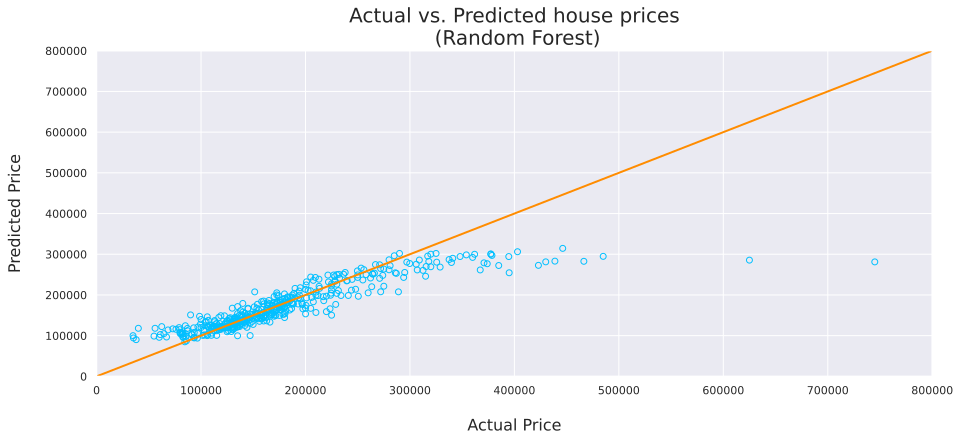

In [80]:
plt.figure(figsize=(15,6))
plt.title("Actual vs. Predicted house prices\n (Random Forest)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(rf_pred),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

O Mape não sofreu alterações, mas o MAE no modelo diminuiu quando usamos Random Forest.

#**Exercício 2**

Na primeira parte do exercício 2 irei passar análise explanatória e pela preparação dos dados tanto para o dataset de mateméticq quanto para o de português. 

Em suma:

* Variáveis binárias de 'yes' e 'no' são substituídas por 1 e 0;
* Variáveis categoricas são mantidas como de 1 a 5, isso pois há uma ordem de grandeza estabelecida então é possível manter os dados como estão;
* Variáveis que identificam a escola, o gênero, endereço e etc são tranformadas em dummies.

Na segunda parte, olho com mais atençao apenas para o consumo de alcool (Dalc e Walc) e como afeta G3. 

Na terceira parte, analiso a importância das variáveis para G3 tanto pelo peso dos coeficientes de uma regressão linear quanto por random forest. Por curiosidade, faço isso considerando tanto o conjunto total dos dados como somente a parte de treino após o split. 

Depois, analiso rapidamente como os dados se comportam dentro de diversos modelos vistos em aula.


In [81]:
uploaded = files.upload()
mat = pd.read_csv(io.BytesIO(uploaded['student-mat.csv']))
por = pd.read_csv(io.BytesIO(uploaded['student-por.csv']))

Saving student-mat.csv to student-mat (1).csv
Saving student-por.csv to student-por (1).csv


In [82]:
# Tirando as variáveis G1 e G2 que devemos ignorar

mat=mat.drop(['G1', 'G2'], axis = 1)
por=por.drop(['G1', 'G2'], axis = 1)

# Parte I: Conhecendo e preparando os dados



Aqui é possível vermos tanto o tamanho dos dataset quanto o tipo das variáveis com as quais estamos trabalhando. Observando os tipos das variáveis, é possível tomarmos decisões, como, por exemplo, tornar as variáveis em dummies.

Neste caso, temos diversas variáveis binárias que são objetos 'yes' ou 'no': schoolsup, famsup, paid, activities, nursery, higher, internet e romantic. 

Enquanto outras variáveis do tipo int64 represetam escalas de 'very low' a 'very high': famrel, freetime, goout, Dalc, Walc e health. Como há uma ordem lógica de grandeza nestas variáveis, não é necessário mudá-las. Caso não houvesse essa ordem, seria necessário fazer a transformação em dummies.

Por fim, as variáveis 'school', 'address', 'famsize' e 'Pstatus' são strings que tem 2 possíveis observações e, assim, podem também ser transformadas em dummies.  

In [83]:
mat.describe(include='all').T

count unique     top freq  mean  std   min   25%   50%   75%   max
school        395      2      GP  349   NaN  NaN   NaN   NaN   NaN   NaN   NaN
sex           395      2       F  208   NaN  NaN   NaN   NaN   NaN   NaN   NaN
age        395.00    NaN     NaN  NaN 16.70 1.28 15.00 16.00 17.00 18.00 22.00
address       395      2       U  307   NaN  NaN   NaN   NaN   NaN   NaN   NaN
famsize       395      2     GT3  281   NaN  NaN   NaN   NaN   NaN   NaN   NaN
Pstatus       395      2       T  354   NaN  NaN   NaN   NaN   NaN   NaN   NaN
Medu       395.00    NaN     NaN  NaN  2.75 1.09  0.00  2.00  3.00  4.00  4.00
Fedu       395.00    NaN     NaN  NaN  2.52 1.09  0.00  2.00  2.00  3.00  4.00
Mjob          395      5   other  141   NaN  NaN   NaN   NaN   NaN   NaN   NaN
Fjob          395      5   other  217   NaN  NaN   NaN   NaN   NaN   NaN   NaN
reason        395      4  course  145   NaN  NaN   NaN   NaN   NaN   NaN   NaN
guardian      395      3  mother  273   NaN  NaN   NaN   NaN   NaN   NaN   NaN
traveltime 395.00    NaN     NaN  NaN  1.45 0.70  1.00  1.00  1.00  2.00  4.00
studytime  395.00    NaN     NaN  NaN  2.04 0.84  1.00  1.00  2.00  2.00  4.00
failures   395.00    NaN     NaN  NaN  0.33 0.74  0.00  0.00  0.00  0.00  3.00
schoolsup     395      2      no  344   NaN  NaN   NaN   NaN   NaN   NaN   NaN
famsup        395      2     yes  242   NaN  NaN   NaN   NaN   NaN   NaN   NaN
paid          395      2      no  214   NaN  NaN   NaN   NaN   NaN   NaN   NaN
activities    395      2     yes  201   NaN  NaN   NaN   NaN   NaN   NaN   NaN
nursery       395      2     yes  314   NaN  NaN   NaN   NaN   NaN   NaN   NaN
higher        395      2     yes  375   NaN  NaN   NaN   NaN   NaN   NaN   NaN
internet      395      2     yes  329   NaN  NaN   NaN   NaN   NaN   NaN   NaN
romantic      395      2      no  263   NaN  NaN   NaN   NaN   NaN   NaN   NaN
famrel     395.00    NaN     NaN  NaN  3.94 0.90  1.00  4.00  4.00  5.00  5.00
freetime   395.00    NaN     NaN  NaN  3.24 1.00  1.00  3.00  3.00  4.00  5.00
goout      395.00    NaN     NaN  NaN  3.11 1.11  1.00  2.00  3.00  4.00  5.00
Dalc       395.00    NaN     NaN  NaN  1.48 0.89  1.00  1.00  1.00  2.00  5.00
Walc       395.00    NaN     NaN  NaN  2.29 1.29  1.00  1.00  2.00  3.00  5.00
health     395.00    NaN     NaN  NaN  3.55 1.39  1.00  3.00  4.00  5.00  5.00
absences   395.00    NaN     NaN  NaN  5.71 8.00  0.00  0.00  4.00  8.00 75.00
G3         395.00    NaN     NaN  NaN 10.42 4.58  0.00  8.00 11.00 14.00 20.00

In [84]:
por.describe(include='all').T

count unique     top freq  mean  std   min   25%   50%   75%   max
school        649      2      GP  423   NaN  NaN   NaN   NaN   NaN   NaN   NaN
sex           649      2       F  383   NaN  NaN   NaN   NaN   NaN   NaN   NaN
age        649.00    NaN     NaN  NaN 16.74 1.22 15.00 16.00 17.00 18.00 22.00
address       649      2       U  452   NaN  NaN   NaN   NaN   NaN   NaN   NaN
famsize       649      2     GT3  457   NaN  NaN   NaN   NaN   NaN   NaN   NaN
Pstatus       649      2       T  569   NaN  NaN   NaN   NaN   NaN   NaN   NaN
Medu       649.00    NaN     NaN  NaN  2.51 1.13  0.00  2.00  2.00  4.00  4.00
Fedu       649.00    NaN     NaN  NaN  2.31 1.10  0.00  1.00  2.00  3.00  4.00
Mjob          649      5   other  258   NaN  NaN   NaN   NaN   NaN   NaN   NaN
Fjob          649      5   other  367   NaN  NaN   NaN   NaN   NaN   NaN   NaN
reason        649      4  course  285   NaN  NaN   NaN   NaN   NaN   NaN   NaN
guardian      649      3  mother  455   NaN  NaN   NaN   NaN   NaN   NaN   NaN
traveltime 649.00    NaN     NaN  NaN  1.57 0.75  1.00  1.00  1.00  2.00  4.00
studytime  649.00    NaN     NaN  NaN  1.93 0.83  1.00  1.00  2.00  2.00  4.00
failures   649.00    NaN     NaN  NaN  0.22 0.59  0.00  0.00  0.00  0.00  3.00
schoolsup     649      2      no  581   NaN  NaN   NaN   NaN   NaN   NaN   NaN
famsup        649      2     yes  398   NaN  NaN   NaN   NaN   NaN   NaN   NaN
paid          649      2      no  610   NaN  NaN   NaN   NaN   NaN   NaN   NaN
activities    649      2      no  334   NaN  NaN   NaN   NaN   NaN   NaN   NaN
nursery       649      2     yes  521   NaN  NaN   NaN   NaN   NaN   NaN   NaN
higher        649      2     yes  580   NaN  NaN   NaN   NaN   NaN   NaN   NaN
internet      649      2     yes  498   NaN  NaN   NaN   NaN   NaN   NaN   NaN
romantic      649      2      no  410   NaN  NaN   NaN   NaN   NaN   NaN   NaN
famrel     649.00    NaN     NaN  NaN  3.93 0.96  1.00  4.00  4.00  5.00  5.00
freetime   649.00    NaN     NaN  NaN  3.18 1.05  1.00  3.00  3.00  4.00  5.00
goout      649.00    NaN     NaN  NaN  3.18 1.18  1.00  2.00  3.00  4.00  5.00
Dalc       649.00    NaN     NaN  NaN  1.50 0.92  1.00  1.00  1.00  2.00  5.00
Walc       649.00    NaN     NaN  NaN  2.28 1.28  1.00  1.00  2.00  3.00  5.00
health     649.00    NaN     NaN  NaN  3.54 1.45  1.00  2.00  4.00  5.00  5.00
absences   649.00    NaN     NaN  NaN  3.66 4.64  0.00  0.00  2.00  6.00 32.00
G3         649.00    NaN     NaN  NaN 11.91 3.23  0.00 10.00 12.00 14.00 19.00

## Organizando o Dataset

Lendo a descrição das variáveis e a descrição estatística feita acima, optei por remover duas  do dataset.

Há tanto variáveis sobre o nível de educação quanto o tipo de emprego dos pais. Entendo que há uma diferença entre as duas variáveis, mas, mais de 35% do Mjob e mais de 54% do Fjob são 'other'. Ou seja, é como se 35 e 55% pas variáveis fossem nulas (no sentido de que não trazem um insight sobre o efeito de determinada profissão). 

Então, por questões de quantidade de dummies no modelo, manterei somente as variáveis de nível de educação - há um concenso que o nível de educação dos pais afeta a educação dos filhos.

Assim, droparei as variáveis *Mjob e Fjob*

In [85]:
mat = mat.drop(['Mjob', 'Fjob'], 1)
por = por.drop(['Mjob', 'Fjob'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


Começando com a transformação das variáveis binárias em numéricas

In [86]:
cols = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
mat[cols] = mat[cols].replace({'yes': 1, 'no': 0})
por[cols] = por[cols].replace({'yes': 1, 'no': 0})


Agora transformando as variáveis 'school', 'address', 'famsize'. 'guardian', 'reason' e 'Pstatus' em dummy e depois dropando uma das colunas dummies gerada para cada variável. 

Isso pois não é necessário manter as duas (ou três) já que 0 significa ausência de uma e, portanto, presença da outra.

In [87]:
mat = pd.get_dummies(
    mat, columns=['sex','school', 'address', 'famsize', 'Pstatus', 'guardian', 'reason'])
mat = mat.drop(['sex_M','school_MS', 'address_R', 'famsize_GT3', 'Pstatus_T', 'guardian_other', 'reason_other'], 1)

por = pd.get_dummies(
    por, columns=['sex','school', 'address', 'famsize', 'Pstatus', 'guardian', 'reason'])
por = por.drop(['sex_M','school_MS', 'address_R', 'famsize_GT3', 'Pstatus_T', 'guardian_other', 'reason_other'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


In [88]:
# Ordenando os dfs para começar com a variável de interesse - G3

cols_to_order = ['G3']
new_columns = cols_to_order + (mat.columns.drop(cols_to_order).tolist())
mat = mat[new_columns]

cols_to_order = ['G3']
new_columns = cols_to_order + (por.columns.drop(cols_to_order).tolist())
por = por[new_columns]


In [89]:
mat.head()

G3  age  Medu  Fedu  traveltime  studytime  failures  schoolsup  famsup  \
0   6   18     4     4           2          2         0          1       0   
1   6   17     1     1           1          2         0          0       1   
2  10   15     1     1           1          2         3          1       0   
3  15   15     4     2           1          3         0          0       1   
4  10   16     3     3           1          2         0          0       1   

   paid  ...  sex_F  school_GP  address_U  famsize_LE3  Pstatus_A  \
0     0  ...      1          1          1            0          1   
1     0  ...      1          1          1            0          0   
2     1  ...      1          1          1            1          0   
3     1  ...      1          1          1            0          0   
4     1  ...      1          1          1            0          0   

   guardian_father  guardian_mother  reason_course  reason_home  \
0                0                1              1            0   
1                1                0              1            0   
2                0                1              0            0   
3                0                1              0            1   
4                1                0              0            1   

   reason_reputation  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 32 columns]

In [90]:
por.head()

G3  age  Medu  Fedu  traveltime  studytime  failures  schoolsup  famsup  \
0  11   18     4     4           2          2         0          1       0   
1  11   17     1     1           1          2         0          0       1   
2  12   15     1     1           1          2         0          1       0   
3  14   15     4     2           1          3         0          0       1   
4  13   16     3     3           1          2         0          0       1   

   paid  ...  sex_F  school_GP  address_U  famsize_LE3  Pstatus_A  \
0     0  ...      1          1          1            0          1   
1     0  ...      1          1          1            0          0   
2     0  ...      1          1          1            1          0   
3     0  ...      1          1          1            0          0   
4     0  ...      1          1          1            0          0   

   guardian_father  guardian_mother  reason_course  reason_home  \
0                0                1              1            0   
1                1                0              1            0   
2                0                1              0            0   
3                0                1              0            1   
4                1                0              0            1   

   reason_reputation  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 32 columns]

## Duplicated values

In [91]:
print(mat.duplicated().value_counts())
print(por.duplicated().value_counts())

False    395
dtype: int64
False    649
dtype: int64


Não há valores duplicados que precisem ser removidos.

## Missing Values

In [92]:
total = mat.isnull().sum().sort_values(ascending=False)
percent = (mat.isnull().sum()/mat.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
G3                   0     0.00
age                  0     0.00
reason_home          0     0.00
reason_course        0     0.00
guardian_mother      0     0.00
guardian_father      0     0.00
Pstatus_A            0     0.00
famsize_LE3          0     0.00
address_U            0     0.00
school_GP            0     0.00
sex_F                0     0.00
absences             0     0.00
health               0     0.00
Walc                 0     0.00
Dalc                 0     0.00
goout                0     0.00
freetime             0     0.00
famrel               0     0.00
romantic             0     0.00
internet             0     0.00

In [93]:
total = por.isnull().sum().sort_values(ascending=False)
percent = (por.isnull().sum()/por.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
G3                   0     0.00
age                  0     0.00
reason_home          0     0.00
reason_course        0     0.00
guardian_mother      0     0.00
guardian_father      0     0.00
Pstatus_A            0     0.00
famsize_LE3          0     0.00
address_U            0     0.00
school_GP            0     0.00
sex_F                0     0.00
absences             0     0.00
health               0     0.00
Walc                 0     0.00
Dalc                 0     0.00
goout                0     0.00
freetime             0     0.00
famrel               0     0.00
romantic             0     0.00
internet             0     0.00

Não há misisng values em nenhuma das bases. 

## Train test split

In [94]:
train_mat, test_mat = train_test_split(mat, test_size=0.3, random_state=1)

In [95]:
train_por, test_por = train_test_split(por, test_size=0.3, random_state=1)

## Normalizing the data: Mat

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


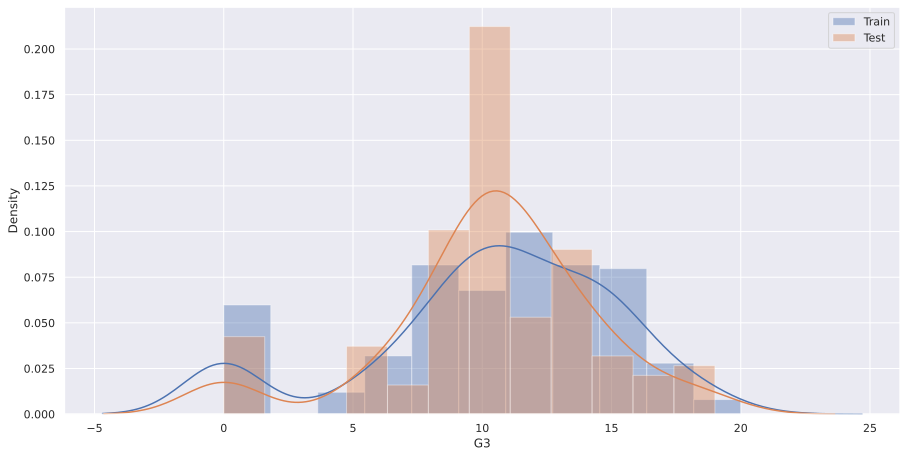

In [96]:
plt.figure(figsize=(15, 7.5))
sns.distplot(train_mat['G3'], kde = True, label='Train');
sns.distplot(test_mat['G3'], kde = True, label='Test');

plt.legend(loc='upper right')
plt.show()

É possível perceber que há uma concentração de observações entre 0 e 2 que 'desnormaliza' a distribuição. 

Entretanto, optarei por lidar com isso na parte de outliers, depois de explorar um pouco mais os dados.

## Normalizing the data: Por

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


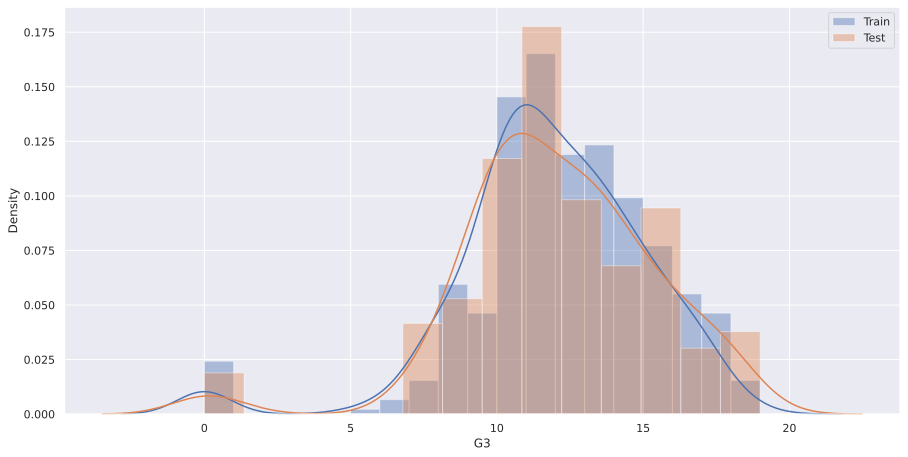

In [97]:
plt.figure(figsize=(15, 7.5))
sns.distplot(train_por['G3'], kde = True, label='Train');
sns.distplot(test_por['G3'], kde = True, label='Test');

plt.legend(loc='upper right')
plt.show()

## Outlier detection: Mat

Matemática

In [98]:
n = 2

upper_limit = train_mat['G3'].mean() + n*train_mat['G3'].std()
lower_limit = train_mat['G3'].mean() - n*train_mat['G3'].std()

print("Highest allowed", upper_limit)
print("Lowest allowed", lower_limit)

Highest allowed 20.057351599983534
Lowest allowed 0.8122136174077728


Áplicando a regra de trimming

In [99]:
train_trimmed = train_mat[
    ( train_mat['G3'] < upper_limit ) & 

    ( train_mat['G3'] > lower_limit )
    ]

In [100]:
train_mat.shape

(276, 32)

In [101]:
train_trimmed.shape #removeu 32 observações

(246, 32)

Aplicando a regra de censoring

In [102]:
train_censored = pd.DataFrame()

train_censored['G3'] =  np.where(
    train_mat['G3'] > upper_limit,
        upper_limit,
        np.where(
            train_mat['G3'] < lower_limit, 
            lower_limit,                   
            train_mat['G3']               
            )
        )

In [103]:
train_censored.shape #não removeu nenhuma observação

(276, 1)

Comparando as duas regras

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

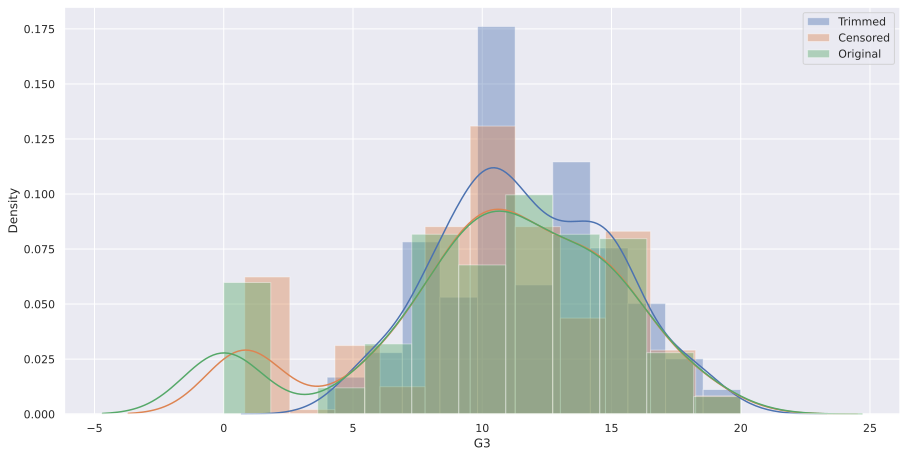

In [104]:
plt.figure(figsize=(15, 7.5))
sns.distplot(train_trimmed['G3'], kde = True, label='Trimmed');
sns.distplot(train_censored['G3'], kde = True, label='Censored');
sns.distplot(train_mat['G3'], kde = True, label='Original')

plt.legend(loc='upper right')
plt.show()

A regra escolhida foi a trimmed pois removeu observações e tornou a distribuição mais próxima da normal.

In [105]:
train_trimmed

G3  age  Medu  Fedu  traveltime  studytime  failures  schoolsup  famsup  \
348  15   17     4     3           1          3         0          0       1   
59   16   16     4     2           1          2         0          0       1   
120  15   15     1     2           1          2         0          0       0   
12   14   15     4     4           1          1         0          0       1   
306  18   20     3     2           1          1         0          0       0   
..   ..  ...   ...   ...         ...        ...       ...        ...     ...   
203   6   17     2     2           1          1         0          0       1   
255   8   17     1     1           2          1         1          0       1   
72    5   15     1     1           1          2         2          1       1   
235  10   16     3     2           2          3         0          0       0   
37   15   16     4     4           2          3         0          0       1   

     paid  ...  sex_F  school_GP  address_U  famsize_LE3  Pstatus_A  \
348     1  ...      1          1          1            0          0   
59      0  ...      1          1          1            0          0   
120     0  ...      1          1          1            0          0   
12      1  ...      0          1          1            1          0   
306     0  ...      0          1          1            0          1   
..    ...  ...    ...        ...        ...          ...        ...   
203     0  ...      1          1          0            0          0   
255     0  ...      0          1          1            1          0   
72      0  ...      1          1          0            0          0   
235     0  ...      0          1          1            0          0   
37      0  ...      0          1          0            0          1   

     guardian_father  guardian_mother  reason_course  reason_home  \
348                0                1              0            0   
59                 0                1              1            0   
120                0                1              1            0   
12                 1                0              1            0   
306                0                0              1            0   
..               ...              ...            ...          ...   
203                0                1              0            0   
255                0                1              1            0   
72                 0                1              0            0   
235                0                1              0            0   
37                 0                1              0            0   

     reason_reputation  
348                  1  
59                   0  
120                  0  
12                   0  
306                  0  
..                 ...  
203                  1  
255                  0  
72                   1  
235                  1  
37                   1  

[246 rows x 32 columns]

## Outlier detection: Por

In [106]:
n = 2

upper_limit = train_por['G3'].mean() + n*train_por['G3'].std()
lower_limit = train_por['G3'].mean() - n*train_por['G3'].std()

print("Highest allowed", upper_limit)
print("Lowest allowed", lower_limit)

Highest allowed 18.220928977126817
Lowest allowed 5.466295692476706


In [107]:
train_trimmed = train_por[
    (train_por['G3'] < upper_limit ) & 

    (train_por['G3'] > lower_limit )
    ]

In [108]:
train_por.shape

(454, 32)

In [109]:
train_trimmed.shape #removeu 13 observações

(441, 32)

In [110]:
train_censored = pd.DataFrame()

train_censored['G3'] =  np.where(
    train_por['G3'] > upper_limit,
        upper_limit,
        np.where(
            train_por['G3'] < lower_limit, 
            lower_limit,                   
            train_por['G3']               
            )
        )

In [111]:
train.shape

(1022, 135)

In [112]:
train_censored.shape #Não excluiu nenhuma observação

(454, 1)

Comparando as duas regras

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

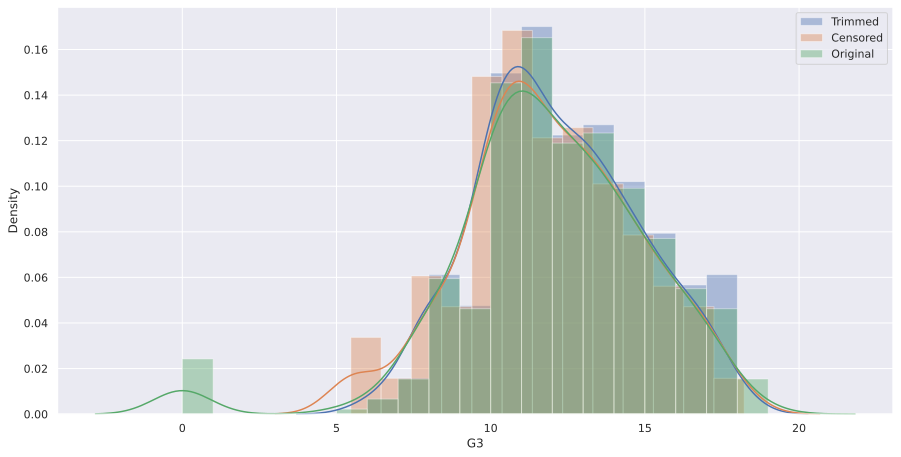

In [113]:
plt.figure(figsize=(15, 7.5))
sns.distplot(train_trimmed['G3'], kde = True, label='Trimmed');
sns.distplot(train_censored['G3'], kde = True, label='Censored');
sns.distplot(train_por['G3'], kde = True, label='Original')

plt.legend(loc='upper right')
plt.show()

A regra escolhida foi a trimmed pois removeu observações e tornou a distribuição mais próxima da normal.

# Parte II: Consumo de bebidas 

Primeiro, investigarei um pouco como o consumo de álcool está distribuido nos dados.

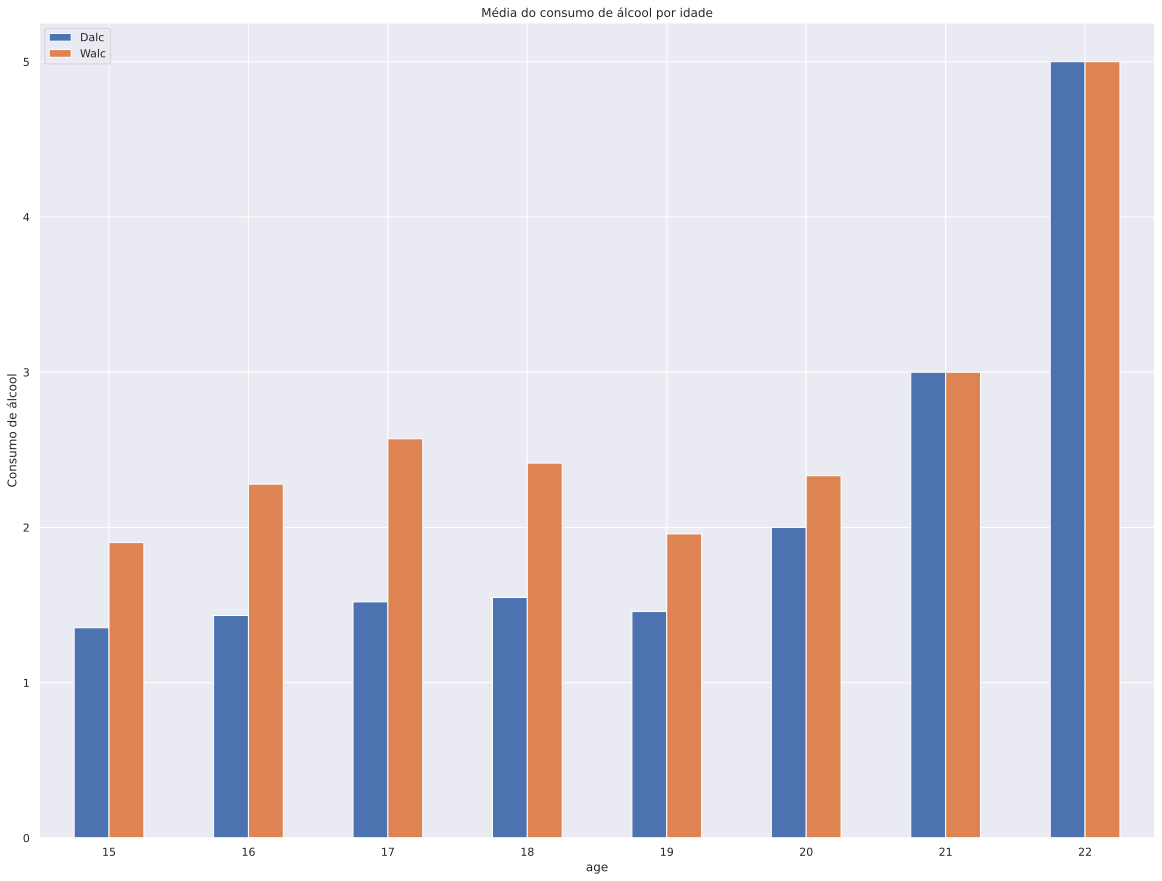

In [114]:
# Começando com idade:

mat.groupby('age')[['Dalc', 'Walc']].mean().plot(kind='bar')
plt.ylabel('Consumo de álcool')
plt.xticks(rotation=0)
plt.title('Média do consumo de álcool por idade')
plt.show()

In [115]:
mat.groupby('age')[['Dalc', 'Walc']].agg(['mean', 'count'])

Dalc       Walc      
    mean count mean count
age                      
15  1.35    82 1.90    82
16  1.43   104 2.28   104
17  1.52    98 2.57    98
18  1.55    82 2.41    82
19  1.46    24 1.96    24
20  2.00     3 2.33     3
21  3.00     1 3.00     1
22  5.00     1 5.00     1

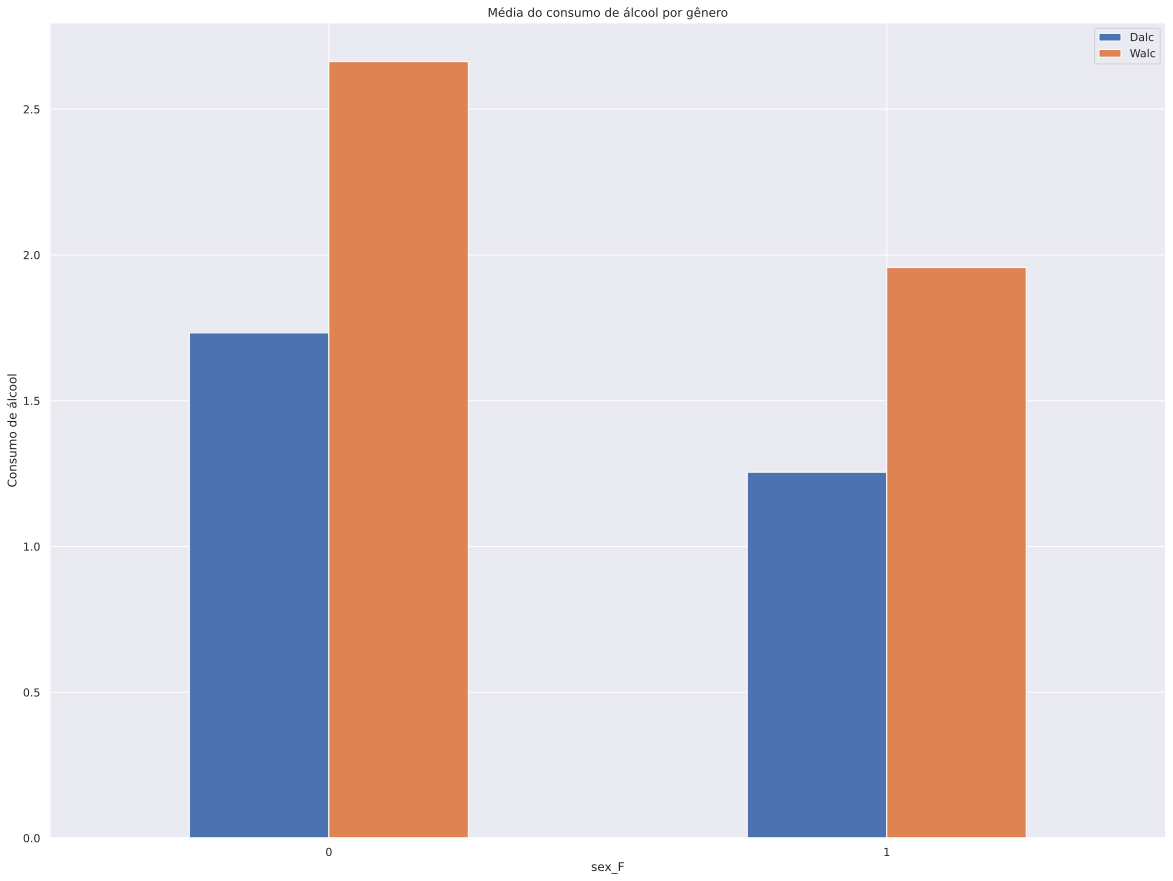

In [116]:
# Agora gênero

mat.groupby('sex_F')[['Dalc', 'Walc']].mean().plot(kind='bar')
plt.ylabel('Consumo de álcool')
plt.xticks(rotation=0)
plt.title('Média do consumo de álcool por gênero')
plt.show()

In [117]:
mat.groupby('sex_F')[['Dalc', 'Walc']].agg(['mean', 'count'])

Dalc       Walc      
      mean count mean count
sex_F                      
0     1.73   187 2.66   187
1     1.25   208 1.96   208

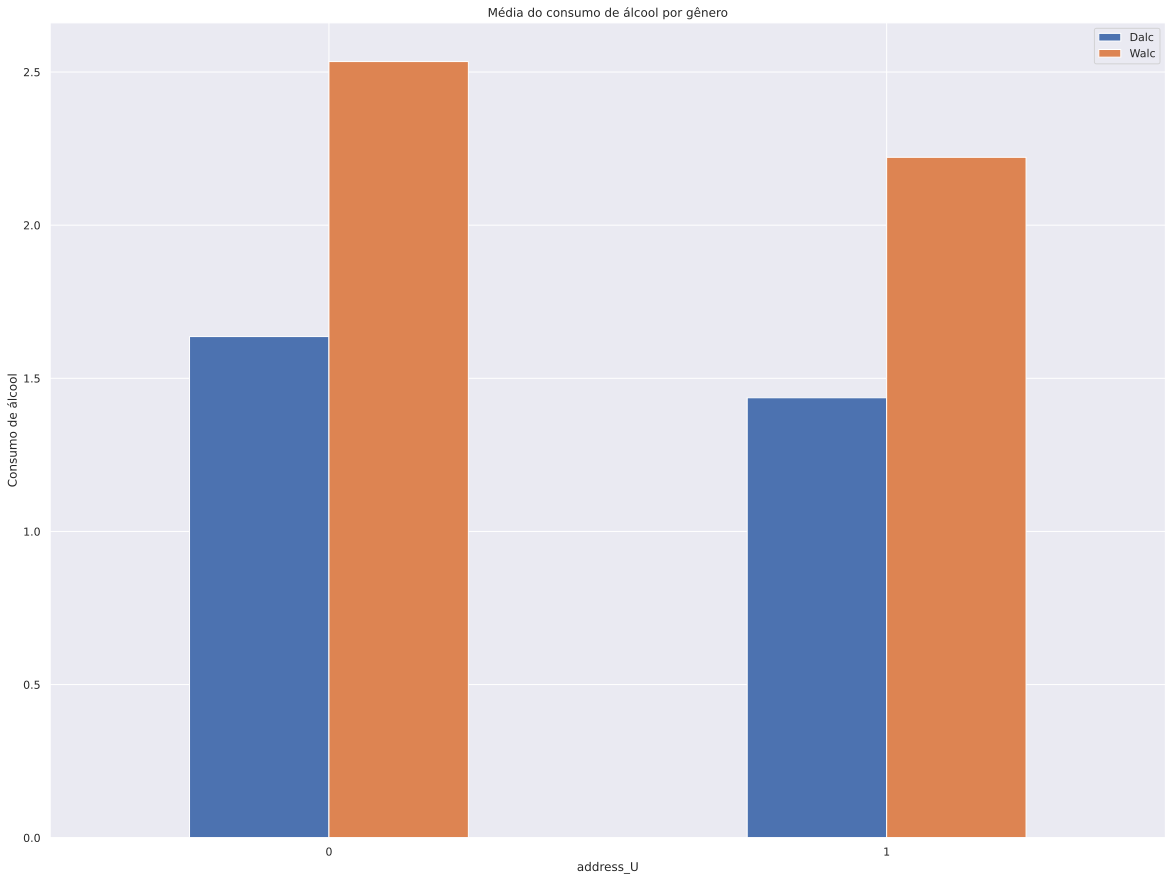

In [118]:
# Agora se mora no ambiente urbano ou rural

mat.groupby('address_U')[['Dalc', 'Walc']].mean().plot(kind='bar')
plt.ylabel('Consumo de álcool')
plt.xticks(rotation=0)
plt.title('Média do consumo de álcool por gênero')
plt.show()

In [119]:
mat.groupby('address_U')[['Dalc', 'Walc']].agg(['mean', 'count'])

Dalc       Walc      
          mean count mean count
address_U                      
0         1.64    88 2.53    88
1         1.44   307 2.22   307

Agora darei uma olhada básica na distribuição de G3 de acordo com consumo de bebidas em dia da semana (Dalc) e em fins de semana (Walc)

In [120]:
mat.groupby('G3')[['Dalc', 'Walc']].agg(['mean', 'count'])

Dalc       Walc      
   mean count mean count
G3                      
0  1.34    38 1.92    38
4  2.00     1 4.00     1
5  2.29     7 3.43     7
6  1.13    15 1.67    15
7  1.56     9 2.78     9
8  1.66    32 2.75    32
9  1.75    28 2.36    28
10 1.54    56 2.75    56
11 1.45    47 2.15    47
12 1.58    31 2.45    31
13 1.90    31 2.48    31
14 1.22    27 1.96    27
15 1.12    33 1.91    33
16 1.38    16 2.19    16
17 1.50     6 1.83     6
18 1.17    12 1.92    12
19 1.00     5 1.20     5
20 1.00     1 1.00     1

<Figure size 1080x432 with 0 Axes>

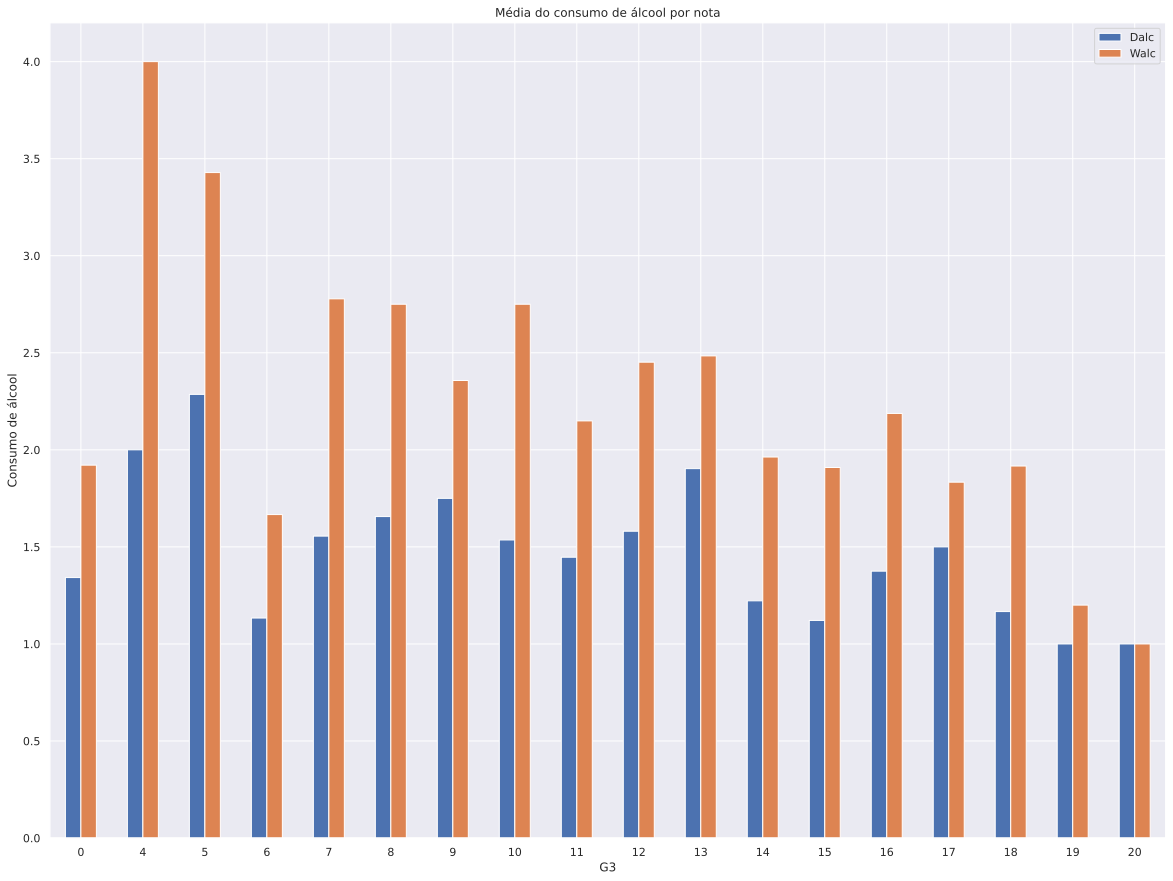

In [121]:
plt.figure(figsize=(15,6))
mat.groupby('G3')[['Dalc', 'Walc']].mean().plot(kind='bar')
plt.ylabel('Consumo de álcool')
plt.xticks(rotation=0)
plt.title('Média do consumo de álcool por nota')
plt.show()

É notável que o consumo de álcool mais alto não é dos alunos com nota 0 e sim dos alunos com notas 4 e 5. Mas, há poucos alunos nessas condições - 8 no total.

In [122]:
mat.groupby('Dalc')['Dalc'].count().to_frame()

# A maioria dos alunos de matemática se encontram no menor nível de consumo, com somente 4.55% estando nos níveis 4 e 5 de consumo. 

Dalc
Dalc      
1      276
2       75
3       26
4        9
5        9

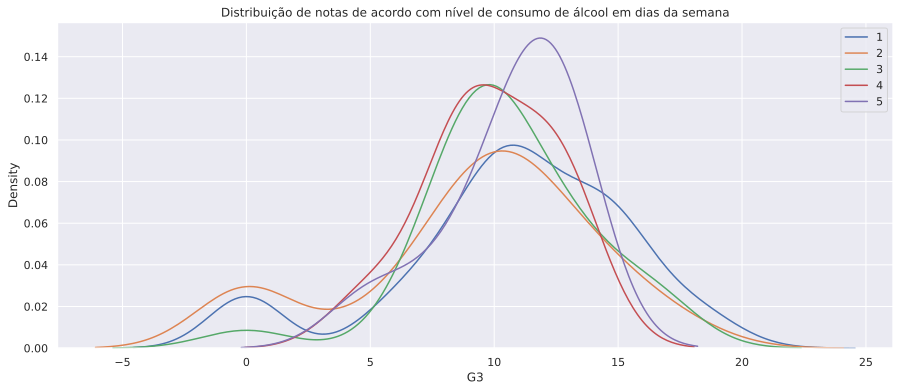

In [123]:
plt.figure(figsize=(15,6))
for dalc, grouped_data in mat.groupby('Dalc'):
    sns.kdeplot(grouped_data['G3'], label=dalc)
plt.legend()
plt.title('Distribuição de notas de acordo com nível de consumo de álcool em dias da semana')
plt.show()

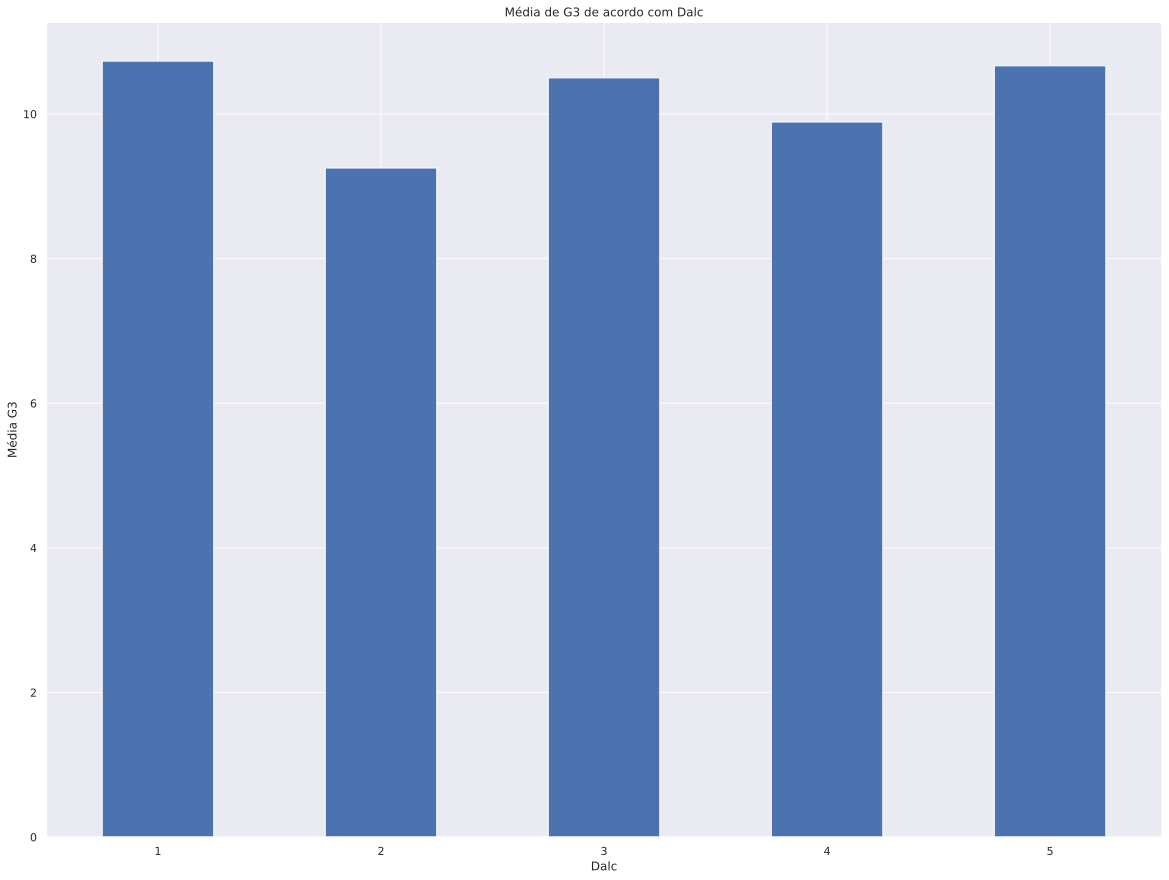

In [124]:
mat.groupby('Dalc')['G3'].mean().plot(kind='bar')
plt.title('Média de G3 de acordo com Dalc')
plt.ylabel('Média G3')
plt.xticks(rotation=0)
plt.show()

As distribuições são diferentes: para alunos com consumo baixo (1 e 2) o pico é um pouco mais largo do que para aqueles com consumo alto (5). A média das notas possuem diferenças, mas não necessariamente as imaginadas: as médias dos alunos com consumo 1 e 5 são bem parecidas, com a menor média estando, na verdade, no consumo de nível 2. Entretanto, os grupos tem tamanhos bem diferentes e a amostra não é muito grande, então não é possível ter certeza da relação. Para aprofundas, farei um teste t.

In [125]:
print(st.ttest_ind(mat.query('Dalc == 1')['G3'], mat.query('Dalc == 2')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Dalc == 1')['G3'], mat.query('Dalc == 3')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Dalc == 1')['G3'], mat.query('Dalc == 4')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Dalc == 1')['G3'], mat.query('Dalc == 5')['G3'], equal_var=False).pvalue)

0.0192878681322908
0.7532307681218111
0.3803184594699919
0.9461400782666927


A diferença do grupo 1 para o 2 é significante, enquanto as outras não. Mas, novamente, isso pode ser causado pela pouca quantidade de alunos nos grupos 3, 4 e 5.

In [126]:
mat.groupby('Walc')['Walc'].count().to_frame()

# A distribuição de Walc é melhor que a de Dalc.
# Apesar da maioria ainda se encontrar no grupo 1, a diferença para os outros grupos é um pouco menor.

Walc
Walc      
1      151
2       85
3       80
4       51
5       28

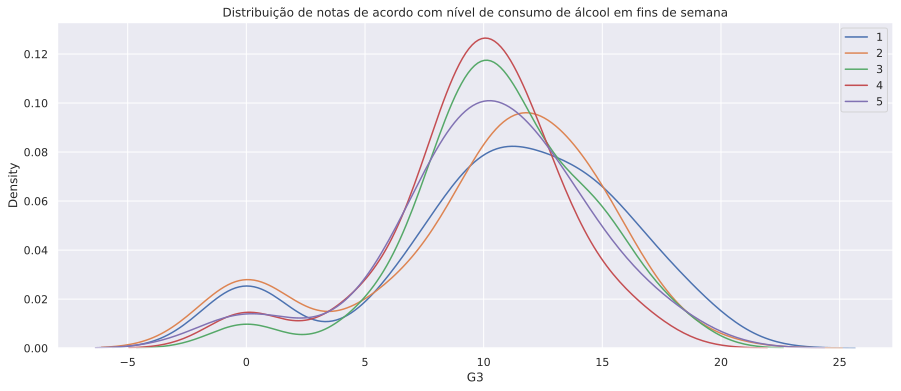

In [127]:
plt.figure(figsize=(15,6))
for walc, grouped_data in mat.groupby('Walc'):
    sns.kdeplot(grouped_data['G3'], label=walc)
plt.legend()
plt.title('Distribuição de notas de acordo com nível de consumo de álcool em fins de semana')
plt.show()

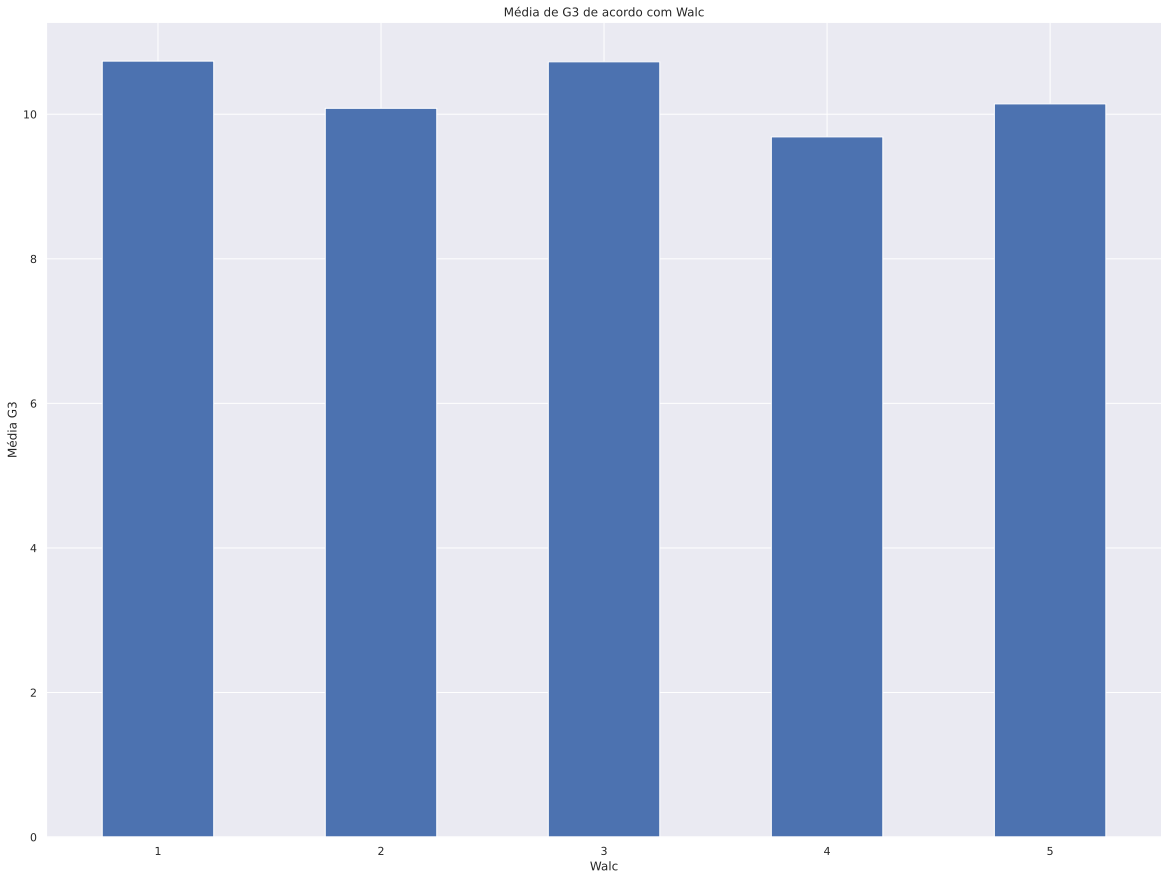

In [128]:
mat.groupby('Walc')['G3'].mean().plot(kind='bar')
plt.title('Média de G3 de acordo com Walc')
plt.ylabel('Média G3')
plt.xticks(rotation=0)
plt.show()

Aqui as distribuições tem picos mais parecidos. A média das notas também tem diferenças pouco gritantes, o que indicaria que não são muito afetadas pelo consumo de álcool

In [129]:
print(st.ttest_ind(mat.query('Walc == 1')['G3'], mat.query('Walc == 2')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Walc == 1')['G3'], mat.query('Walc == 3')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Walc == 1')['G3'], mat.query('Walc == 4')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Walc == 1')['G3'], mat.query('Walc == 5')['G3'], equal_var=False).pvalue)

0.33861317193348284
0.986312737283795
0.11288165231654103
0.5065951077806268


Realmente, não há significância estatística na diferença entre os grupos.

## Mas e se agregarmos o consumo de álcool?

É possível que haja um efeito na nota quando consideramos o consumo de álcool total do aluno, o que analisarei aqui.

In [130]:
mat['Talc'] = mat['Dalc'] + mat['Walc']

In [131]:
mat.groupby('Talc')['Talc'].count().to_frame()

Talc
Talc      
2      150
3       66
4       60
5       45
6       35
7       17
8        9
9        4
10       9

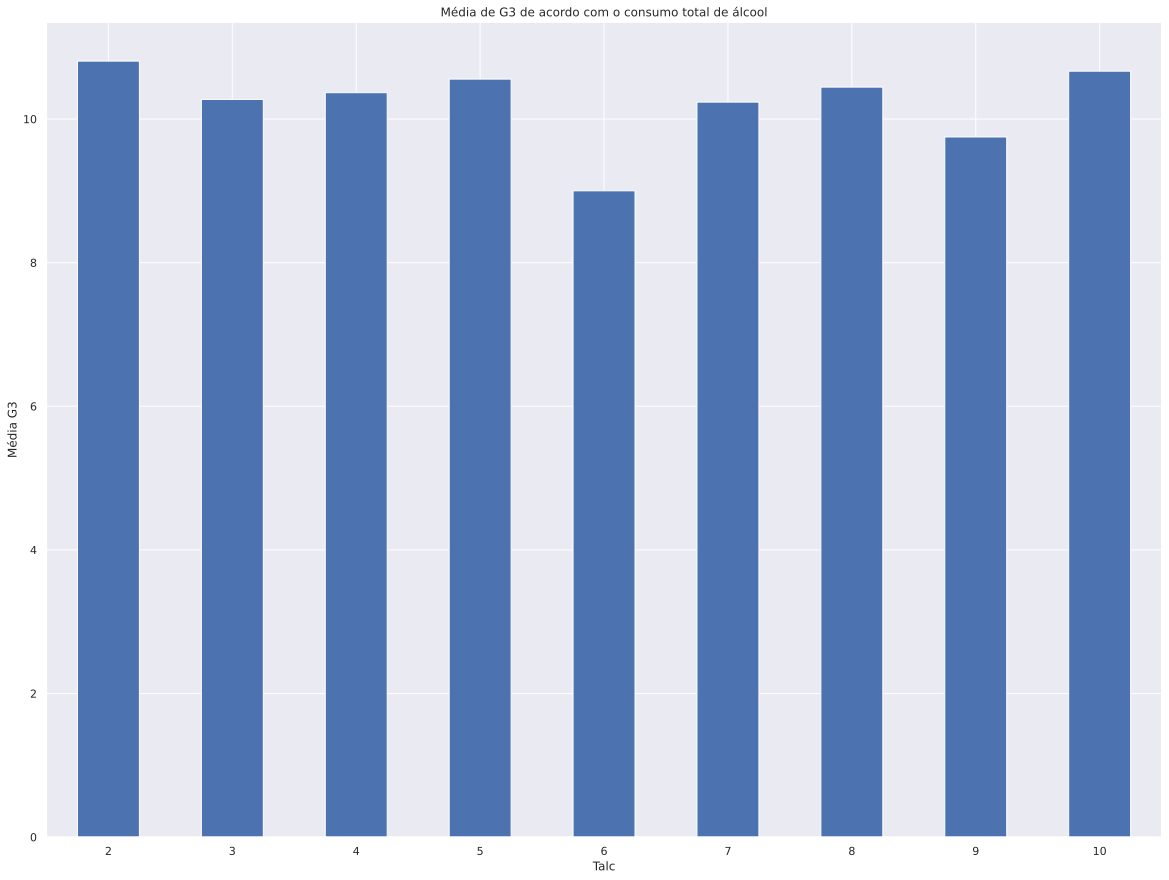

In [132]:
mat.groupby('Talc')['G3'].mean().plot(kind='bar')
plt.title('Média de G3 de acordo com o consumo total de álcool')
plt.ylabel('Média G3')
plt.xticks(rotation=0)
plt.show()

In [133]:
mat.groupby('G3')[['Talc', 'Dalc', 'Walc']].agg(['mean', 'count'])

Talc       Dalc       Walc      
   mean count mean count mean count
G3                                 
0  3.26    38 1.34    38 1.92    38
4  6.00     1 2.00     1 4.00     1
5  5.71     7 2.29     7 3.43     7
6  2.80    15 1.13    15 1.67    15
7  4.33     9 1.56     9 2.78     9
8  4.41    32 1.66    32 2.75    32
9  4.11    28 1.75    28 2.36    28
10 4.29    56 1.54    56 2.75    56
11 3.60    47 1.45    47 2.15    47
12 4.03    31 1.58    31 2.45    31
13 4.39    31 1.90    31 2.48    31
14 3.19    27 1.22    27 1.96    27
15 3.03    33 1.12    33 1.91    33
16 3.56    16 1.38    16 2.19    16
17 3.33     6 1.50     6 1.83     6
18 3.08    12 1.17    12 1.92    12
19 2.20     5 1.00     5 1.20     5
20 2.00     1 1.00     1 1.00     1

In [134]:
print(st.ttest_ind(mat.query('Talc == 2')['G3'], mat.query('Talc == 3')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Talc == 2')['G3'], mat.query('Talc == 4')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Talc == 2')['G3'], mat.query('Talc == 5')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Talc == 2')['G3'], mat.query('Talc == 6')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Talc == 2')['G3'], mat.query('Talc == 7')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Talc == 2')['G3'], mat.query('Talc == 8')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Talc == 2')['G3'], mat.query('Talc == 9')['G3'], equal_var=False).pvalue)
print(st.ttest_ind(mat.query('Talc == 2')['G3'], mat.query('Talc == 10')['G3'], equal_var=False).pvalue)

0.4730833845032465
0.5265773086822543
0.7089327119651319
0.024576900806196168
0.6090765367765631
0.8304620937577545
0.42370177738369236
0.8897801960595911


Somente o nível 6 de consumo total aparenta ter algum efeito estatisticamente siginificante.

In [135]:
mat = mat.drop(['Talc'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


## Regressões só com consumo de álcool

In [136]:
train_alc, test_alc = train_test_split(mat, test_size=0.3, random_state=7)

X_lr = sm.add_constant( train_alc[['Dalc', 'Walc']] )
X_lr_test = sm.add_constant( test_alc[['Dalc', 'Walc']])
linear_reg = LinearRegression()
linear_reg = sm.OLS(train_alc[['G3']], X_lr  )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_lr_test)
print(linear_reg_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5637
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.570
Time:                        18:57:49   Log-Likelihood:                -818.63
No. Observations:                 276   AIC:                             1643.
Df Residuals:                     273   BIC:                             1654.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5717      0.610     17.332      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [137]:
# Ridge

ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(train_alc[['Dalc', 'Walc']], train_alc[['G3']] )
ridge_pred = ridge_reg.predict(test_alc[['Dalc', 'Walc']])

In [138]:
ridge_reg.coef_

array([[ 0.02576615, -0.24649678]])

In [139]:
# Lasso

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train_alc[['Dalc', 'Walc']], train_alc[['G3']])

lasso_pred = model_lasso.predict(test_alc[['Dalc', 'Walc']])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [140]:
model_lasso.coef_

array([-0., -0.])

In [141]:
# Elastic Net

model_ElasticNet = ElasticNetCV(
    l1_ratio = 0.5,
    alphas = [1, 0.1, 0.001, 0.0005],
    fit_intercept = True
).fit(train_alc[['Dalc', 'Walc']], train_alc[['G3']] )

elastic_pred = model_ElasticNet.predict(test_alc[['Dalc', 'Walc']])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [142]:
model_ElasticNet.coef_

array([-0., -0.])

Em conclusão, o consumo de álcool, seja na semana ou em fins de semana, não possui um efeito quantitativo forte nem estatisticamente significante na nota dos alunos.

# Parte III: importância das variáveis

## Matemática

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x432 with 0 Axes>

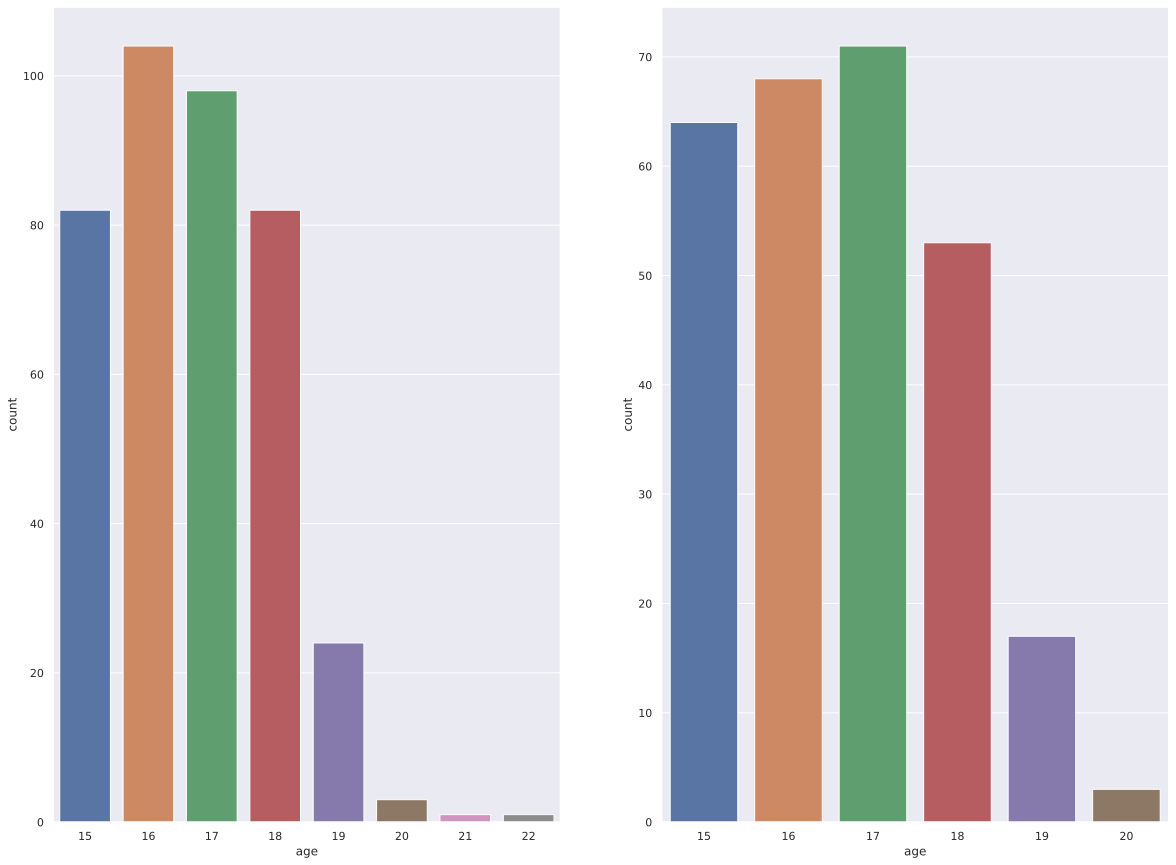

In [143]:
# Primeiro irei olhar a distribuição das idades e considerar seu efeito em G3.

plt.figure(figsize=(15,6))
fig, ax =plt.subplots(1,2)
sns.countplot(mat['age'], ax=ax[0])
sns.countplot(train_mat['age'], ax=ax[1])
fig.show()

#Aqui fica claro que o conjunto total possui alguns estudantes de 21 e 22 anos, enquanto o conjunto de treino possui estudantes até 20 anos.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


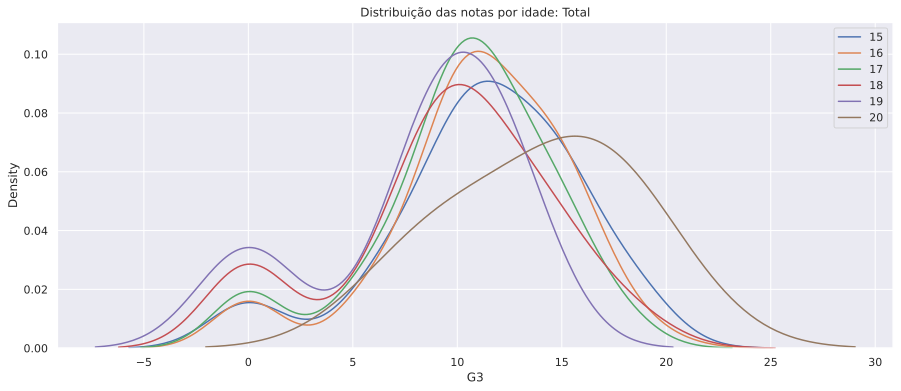

In [144]:
plt.figure(figsize=(15,6))
for age, grouped_data in mat.groupby('age'):
        sns.kdeplot(grouped_data['G3'], label=age)
plt.legend()
plt.title('Distribuição das notas por idade: Total')
plt.show()

# A distribuição aparenta ser normal para até 19 anos, com 20 puxando um pouco mais para a direita.

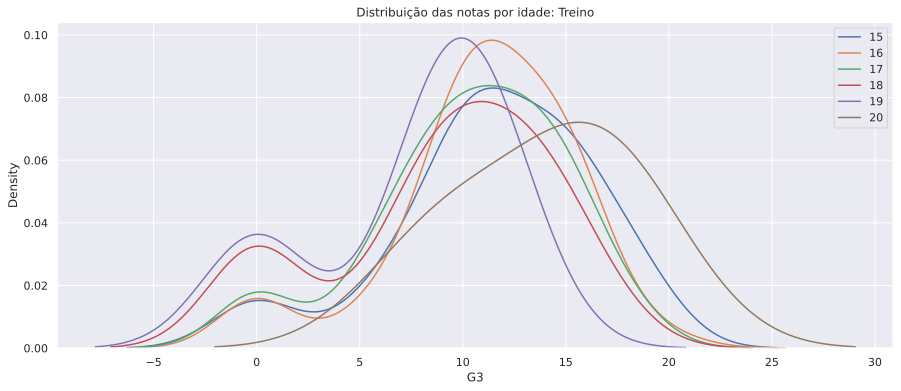

In [145]:
plt.figure(figsize=(15,6))
for age, grouped_data in train_mat.groupby('age'):
        sns.kdeplot(grouped_data['G3'], label=age)
plt.legend()
plt.title('Distribuição das notas por idade: Treino')
plt.show()

# A distribuição das notas por idade é  similar no conjunto total e no de treino, com a diferença que o conjunto de treino é um pouco 'puxado' para a direita.

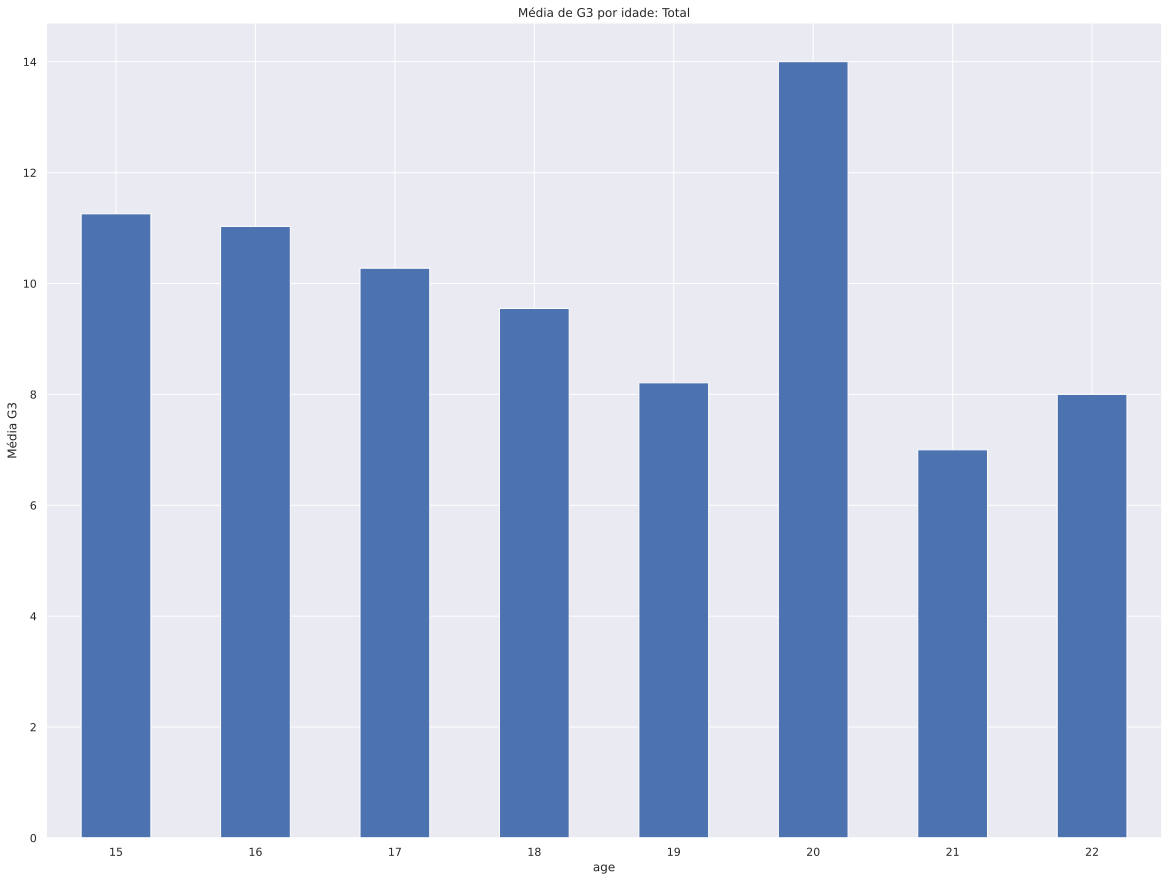

In [146]:
mat.groupby('age')['G3'].mean().plot(kind='bar')
plt.title('Média de G3 por idade: Total')
plt.ylabel('Média G3')
plt.xticks(rotation=0)
plt.show()

# É notável que há uma tendência de queda nas notas até os 19 anos. Nos 20, entretanto, os alunos aparentam ter uma melhora considerável na nota - com a média batendo 14. 

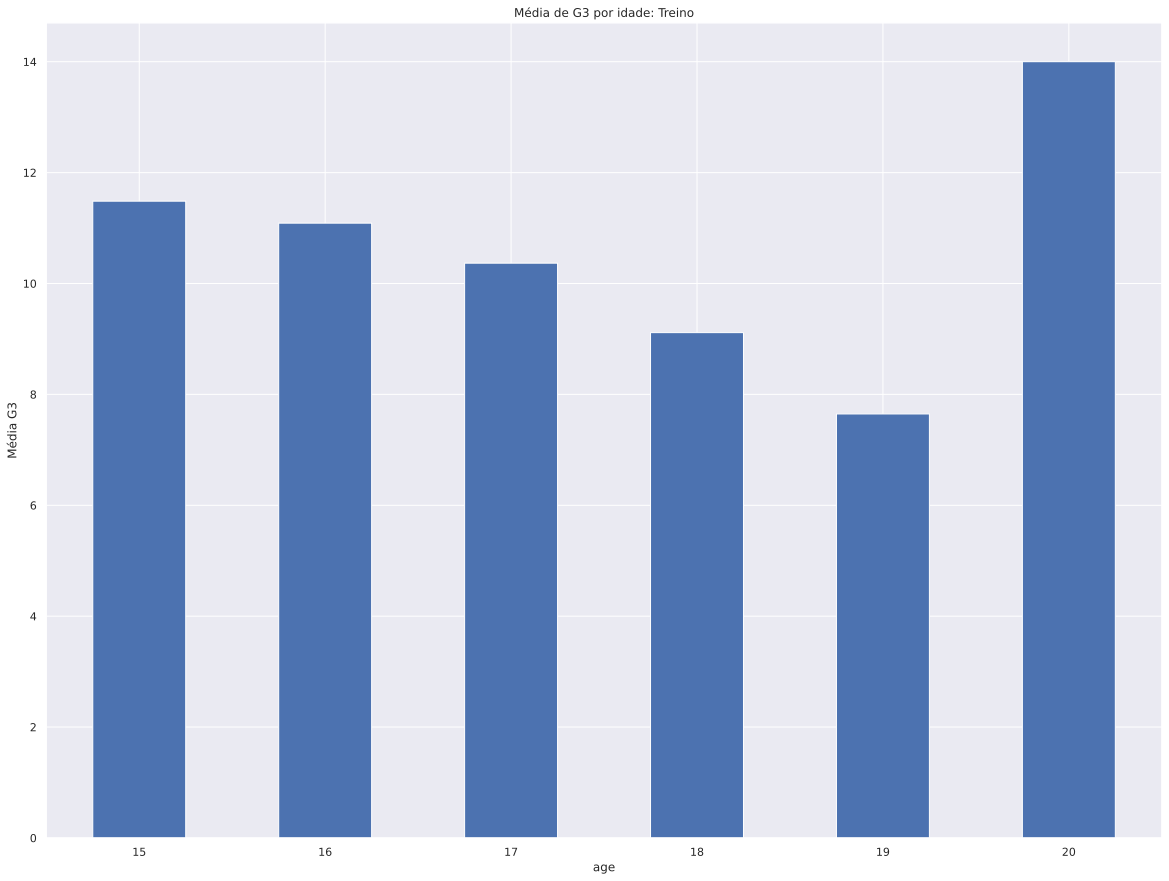

In [147]:
train_mat.groupby('age')['G3'].mean().plot(kind='bar')
plt.title('Média de G3 por idade: Treino')
plt.ylabel('Média G3')
plt.xticks(rotation=0)
plt.show()

# O mesmo padrão se repete no conjunto de treino:  até os 19 anos há uma tendência de queda e, aos 20, a média sobe.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x432 with 0 Axes>

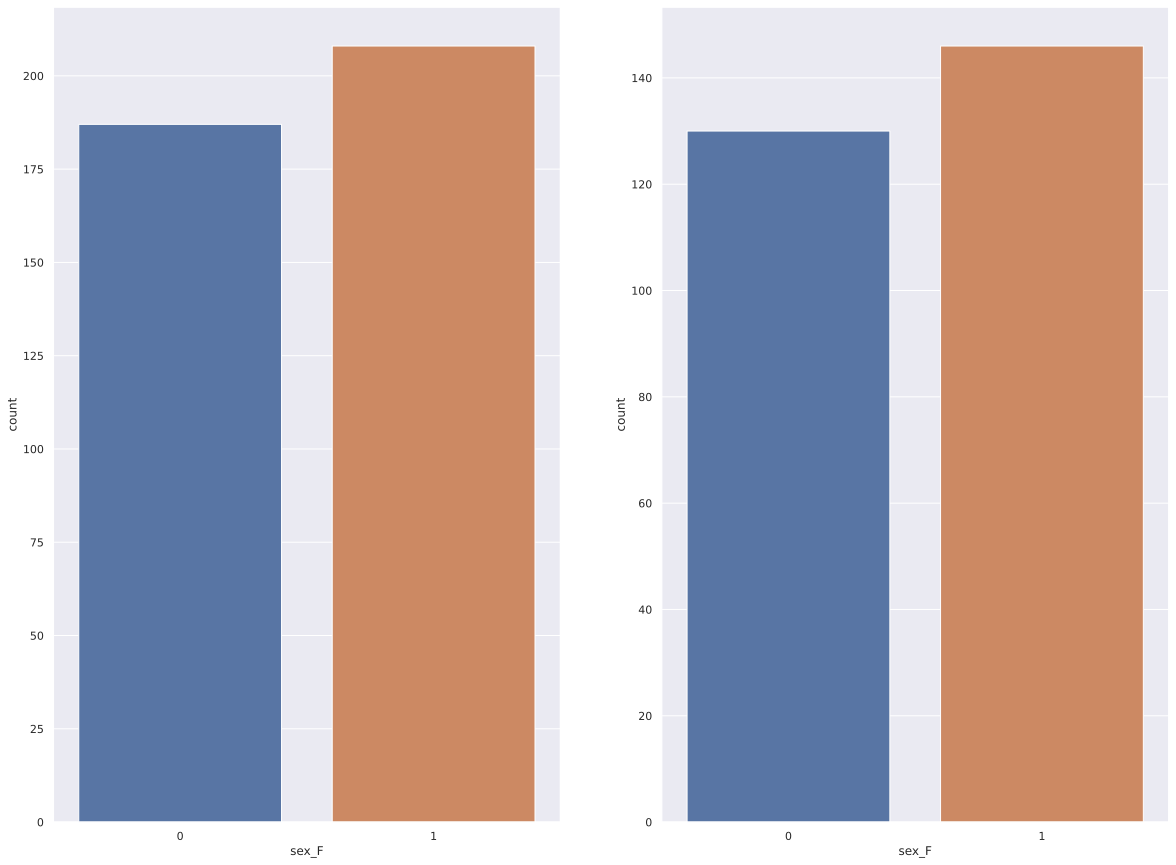

In [148]:
# Agora vou fazer o mesmo para gênero.

plt.figure(figsize=(15,6))
fig, ax =plt.subplots(1,2)
sns.countplot(mat['sex_F'], ax=ax[0])
sns.countplot(train_mat['sex_F'], ax=ax[1])
fig.show()

# É possível perceber que em ambos os conjuntos há mais mulheres (1) do que homens (0)

In [149]:
mat.groupby('sex_F')[['G3']].mean()

# Aqui notamos que a média das notas para homens (0) é um pouco maior do que a de mulheres (1)

G3
sex_F      
0     10.91
1      9.97

In [150]:
train_mat.groupby('sex_F')[['G3']].mean()

# O mesmo padrão se repete aqui no conjunto de teste

G3
sex_F      
0     10.95
1      9.97

Agora irei tentar analisar a importância de cada feature. Novamente, o modelo não está sendo construído aqui, é somente um exercício de observar a importância de cada variável. 

Correlação não é um bom modo de definir a importância de cada variável aqui pois temos muitas variáveis dummy e categóricas. 
Correlação seria uma boa abordagem para variáveis numéricas (que aqui são somente age, failures e absences)
Então, irei colocar todas as variáveis numa mesma escala, para que seja possível estimar o peso de cada coeficiente. 

In [151]:

features_t_imp = train_mat.copy().drop(['G3'], axis=1)
target_t_imp = train_mat.copy()['G3']

In [152]:
# Agora é necessário deixar todas as variáveis na mesma escala
# Peguei este método no Kaggle (https://www.kaggle.com/code/ruslansikhamov)

scaler_num = StandardScaler()
features_t_imp[['age', 'absences']] = scaler_num.fit_transform(features_t_imp[['age', 'absences']])

In [153]:
linear_regressor = LinearRegression()
linear_regressor.fit(features_t_imp, target_t_imp)

LinearRegression()

In [154]:
linear_regressor = LinearRegression()
linear_regressor.fit(features_t_imp, target_t_imp)

feature_importances_lr_coef = pd.concat([pd.Series(features_t_imp.columns, name='features'), 
                                         pd.Series(linear_regressor.coef_, name='weights')],
                                        axis=1) #criando df com os pesos das features 

feature_importances_lr_coef['weights'] = abs(feature_importances_lr_coef['weights']) # como quero saber o peso, vou analisar o valor absoluto
feature_importances_lr_coef = feature_importances_lr_coef.sort_values(by='weights', ascending=False).reset_index(drop=True) #classificando pelo peso

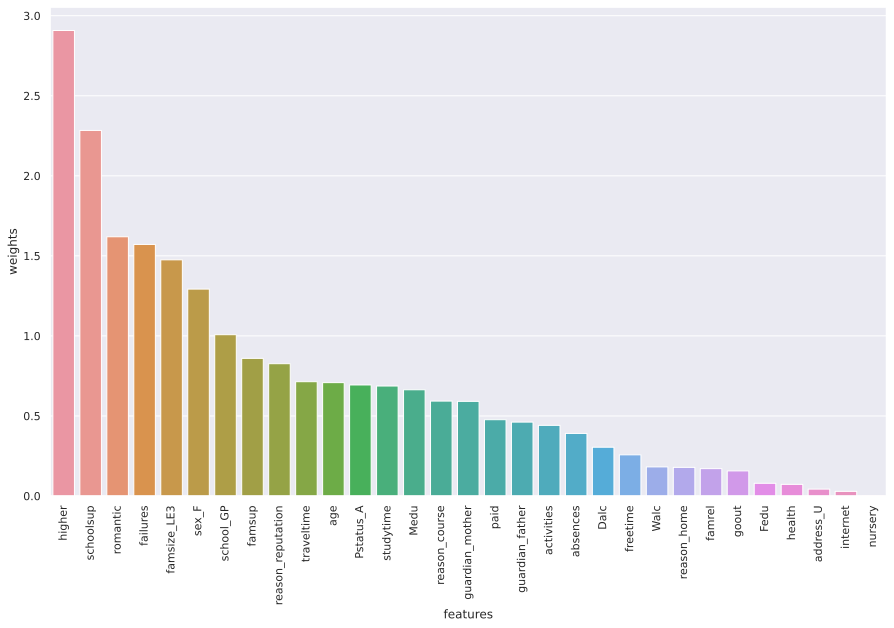

In [155]:
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_lr_coef, x='features', y='weights')
plt.xticks(rotation=90)
plt.show()

É curioso que, no conjunto de treino, há uma mudança no peso das variáveis.
 * Querer educação superior passa a ser a variável de maior peso
 * Suplemento escolar passa a ser a segunda
 * Em terceiro temos se está em um relacionamento ou não
 * Failures passados 
 * E ser de uma família LE3 

E se usarmos outro tipo de regressão?

In [156]:
# Ridge

ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(features_t_imp, target_t_imp)

feature_importances_rr_coef = pd.concat([pd.Series(features_t_imp.columns, name='features'), 
                                         pd.Series(ridge_reg.coef_, name='weights')],
                                        axis=1)

feature_importances_rr_coef['weights'] = abs(feature_importances_rr_coef['weights'])
feature_importances_rr_coef = feature_importances_rr_coef.sort_values(by='weights', ascending=False).reset_index(drop=True)

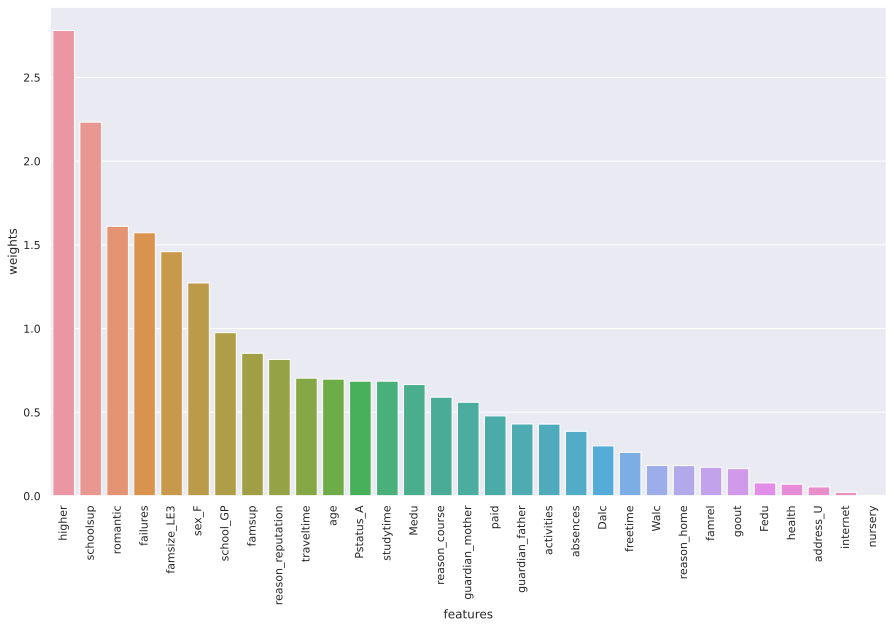

In [157]:
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_rr_coef, x='features', y='weights')
plt.xticks(rotation=90)
plt.show()

Aqui é notável que as top 5 variáveis são as mesmas do modelo de regressão linear. A diferença na ordem começa a partir da décima variável. Ademais, é possível notar que as variáveis mais para a direita tem peso menor aqui do que no modelo de reg linear.

In [158]:
# Lasso

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(features_t_imp, target_t_imp)


feature_importances_lr_coef = pd.concat([pd.Series(features_t_imp.columns, name='features'), 
                                         pd.Series(model_lasso.coef_, name='weights')],
                                        axis=1)

feature_importances_lr_coef['weights'] = abs(feature_importances_lr_coef['weights'])
feature_importances_lr_coef = feature_importances_lr_coef.sort_values(by='weights', ascending=False).reset_index(drop=True)

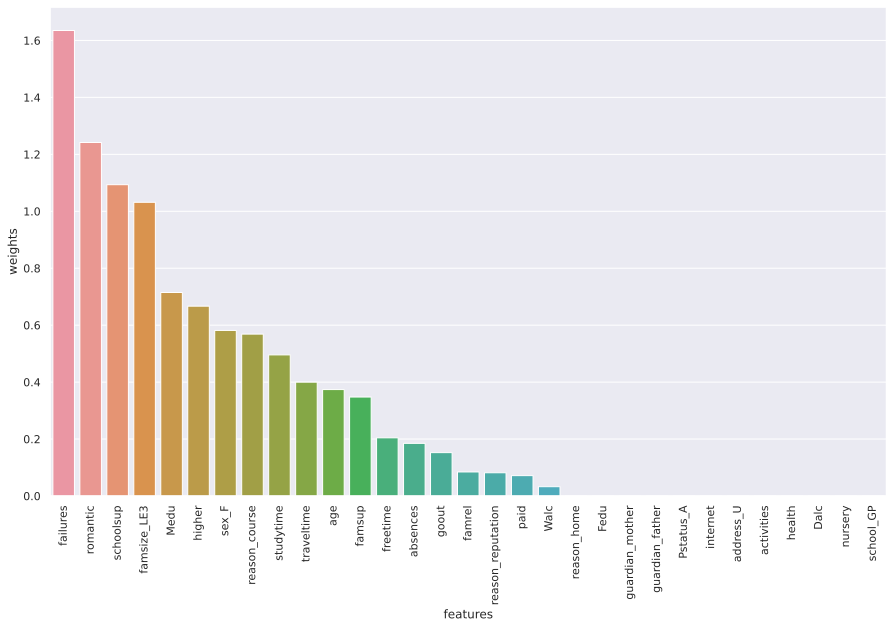

In [159]:
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_lr_coef, x='features', y='weights')
plt.xticks(rotation=90)
plt.show()

Aqui, as top 5 features são:

* failures passados
* se está em um relacionamento 
* suplemento escolar
* tamanho da família LE3
* educação da mãe

Também é notável que aqui 12 variáveis chegam a ser zeradas, o que não ocorre nem em regressões lineares nem em ridge.

## Português

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x432 with 0 Axes>

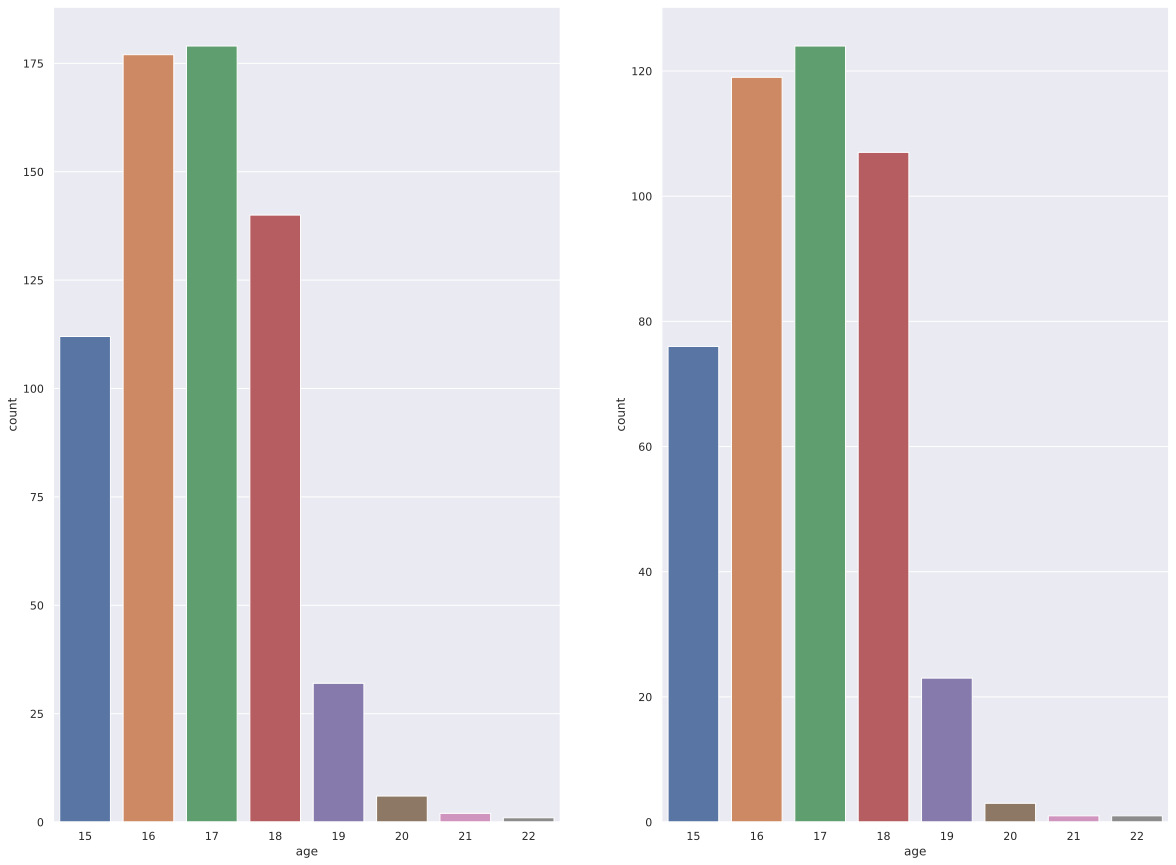

In [160]:
plt.figure(figsize=(15,6))
fig, ax =plt.subplots(1,2)
sns.countplot(por['age'], ax=ax[0])
sns.countplot(train_por['age'], ax=ax[1])
fig.show()

# Aqui, diferentemente de mat, há representantes de todas as idades no conjunto de treino.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


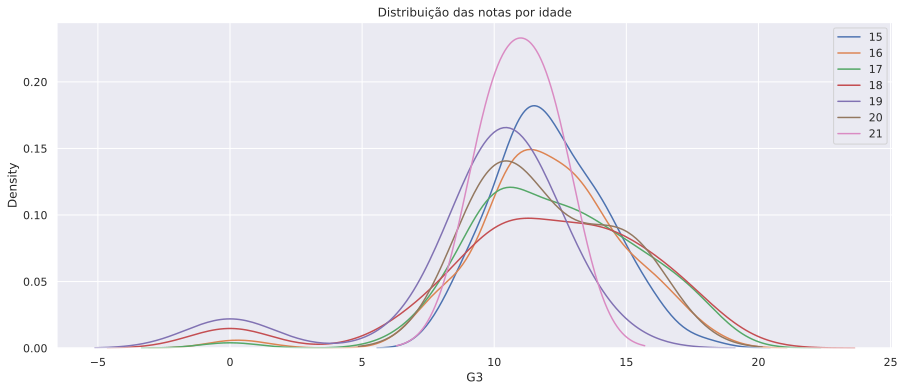

In [161]:
plt.figure(figsize=(15,6))
for age, grouped_data in por.groupby('age'):
        sns.kdeplot(grouped_data['G3'], label=age)
plt.legend()
plt.title('Distribuição das notas por idade')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


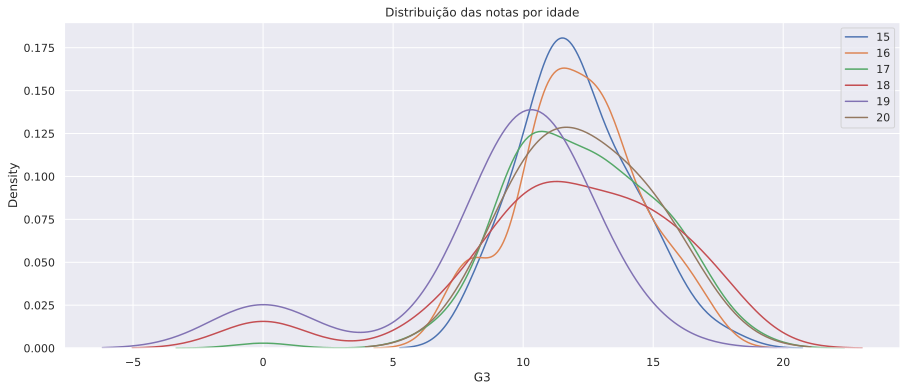

In [162]:
plt.figure(figsize=(15,6))
for age, grouped_data in train_por.groupby('age'):
        sns.kdeplot(grouped_data['G3'], label=age)
plt.legend()
plt.title('Distribuição das notas por idade')
plt.show()

# Aqui as distribuições não parecem tão 'normais' quanto estavam em mat. Mas não deixam de estar relativamente similares.

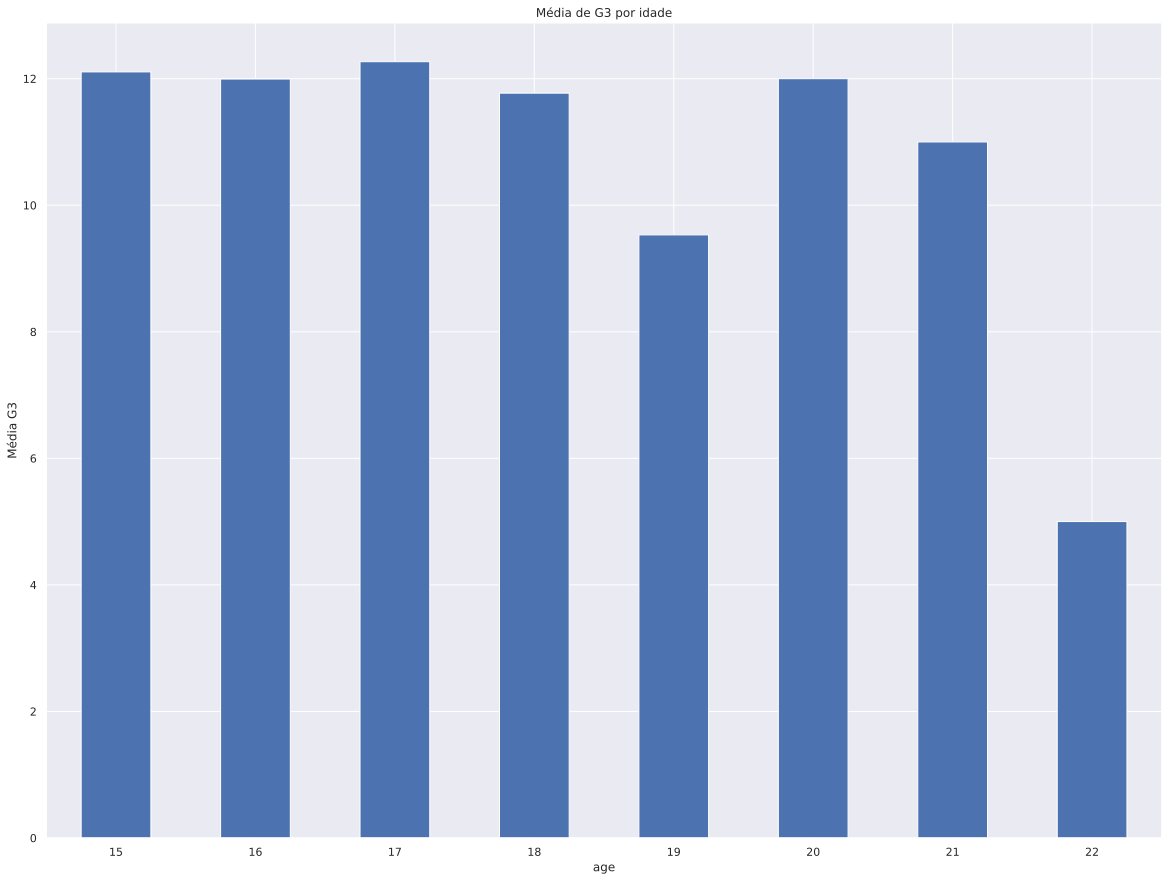

In [163]:
por.groupby('age')['G3'].mean().plot(kind='bar')
plt.title('Média de G3 por idade')
plt.ylabel('Média G3')
plt.xticks(rotation=0)
plt.show()

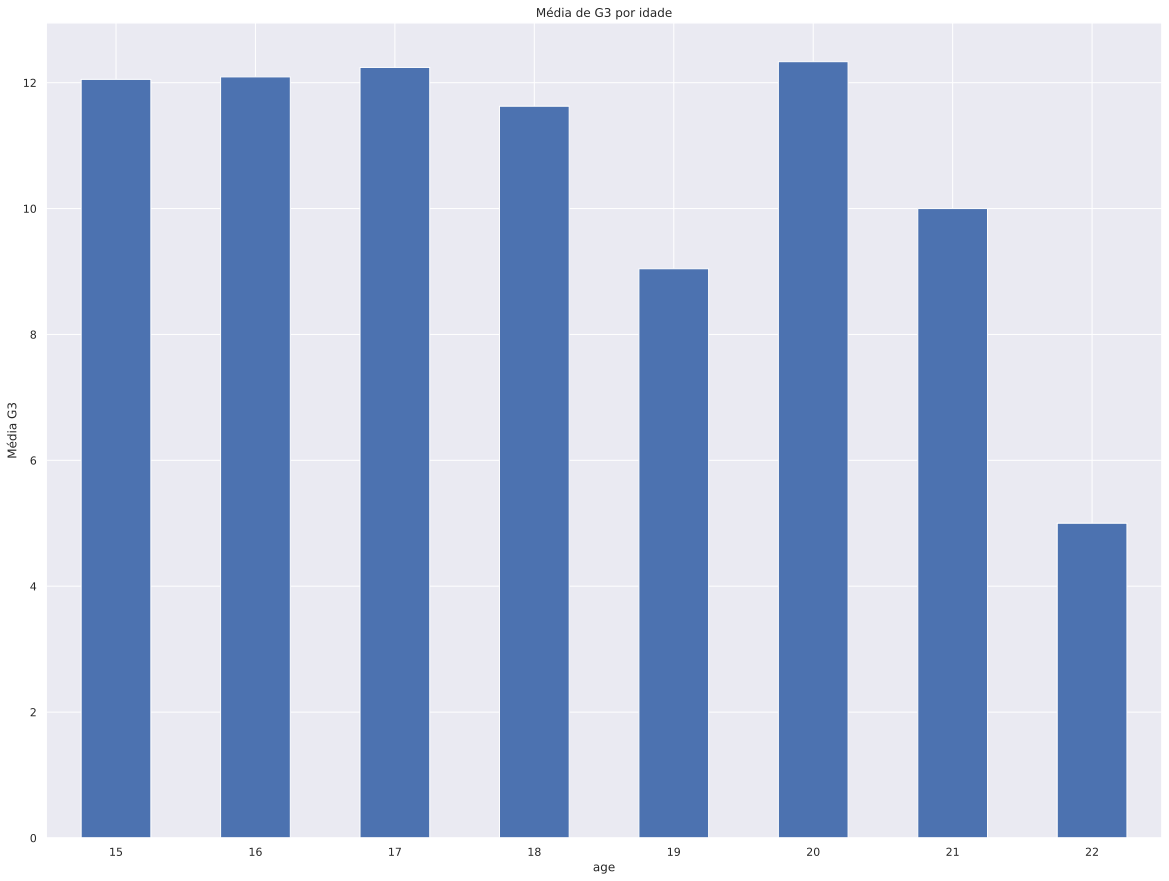

In [164]:
train_por.groupby('age')['G3'].mean().plot(kind='bar')
plt.title('Média de G3 por idade')
plt.ylabel('Média G3')
plt.xticks(rotation=0)
plt.show()

# Apesar das diferenças de distribuição, percebe-se que a relação idade-nota segue o mesmo padrão no conjunto total e no conjunto de dados:
# Notas similares de 15 até 18, queda em 19, subida em 20 e queda em 21 e 22.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x432 with 0 Axes>

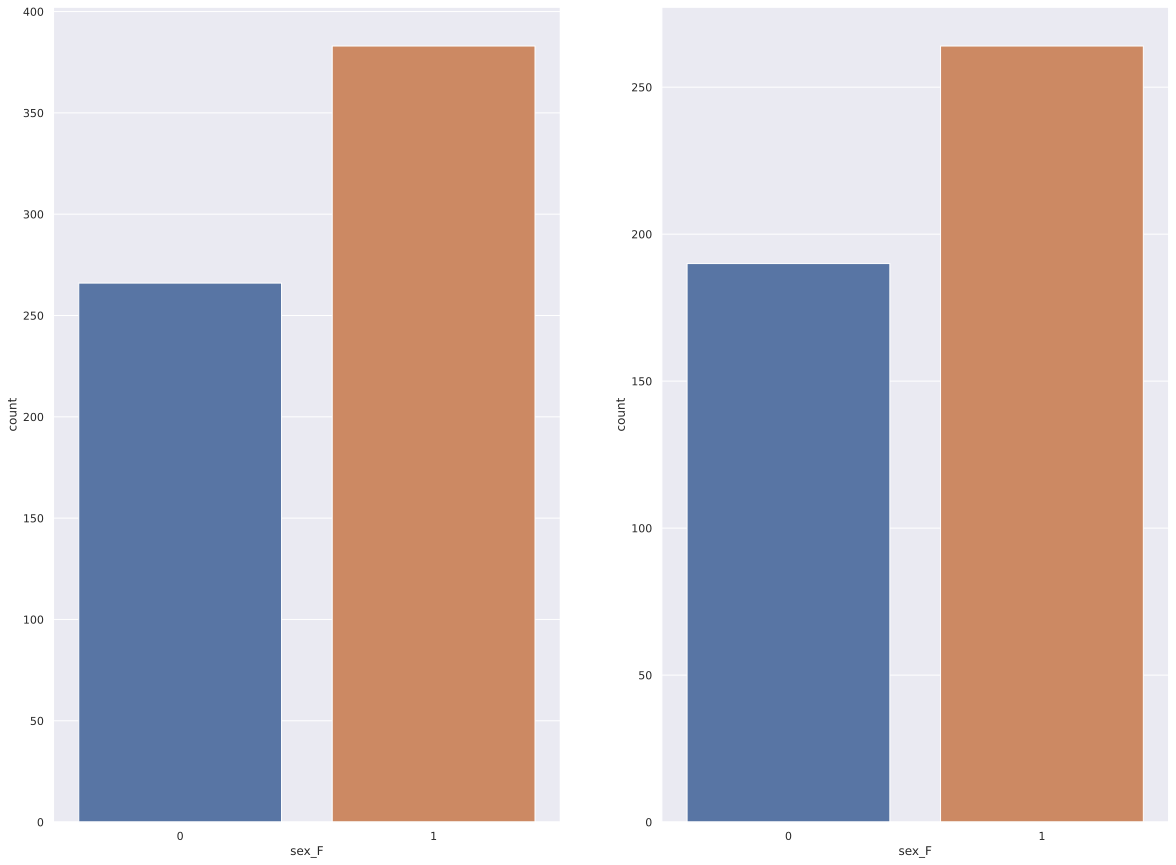

In [165]:
# Agora vou fazer o mesmo para gênero.

plt.figure(figsize=(15,6))
fig, ax =plt.subplots(1,2)
sns.countplot(por['sex_F'], ax=ax[0])
sns.countplot(train_por['sex_F'], ax=ax[1])
fig.show()

# Novamente, há mais mulheres do que homens.

In [166]:
por.groupby('sex_F')[['G3']].mean()


G3
sex_F      
0     11.41
1     12.25

In [167]:
train_por.groupby('sex_F')[['G3']].mean()

# Aqui, as coisas se invertem: a média de mulheres é mais alta que a de homens, tanto no conjunto total quanto no de treino.

G3
sex_F      
0     11.35
1     12.20

In [168]:
# Agora, os coeficientes:
features_t_imp = train_por.copy().drop(['G3'], axis=1)
target_t_imp = train_por.copy()['G3']

In [169]:
scaler_num = StandardScaler()
features_t_imp[['age', 'absences']] = scaler_num.fit_transform(features_t_imp[['age', 'absences']])

In [170]:
linear_regressor = LinearRegression()
linear_regressor.fit(features_t_imp, target_t_imp)

feature_importances_lr_coef = pd.concat([pd.Series(features_t_imp.columns, name='features'), 
                                         pd.Series(linear_regressor.coef_, name='weights')],
                                        axis=1)

feature_importances_lr_coef['weights'] = abs(feature_importances_lr_coef['weights'])
feature_importances_lr_coef = feature_importances_lr_coef.sort_values(by='weights', ascending=False).reset_index(drop=True)

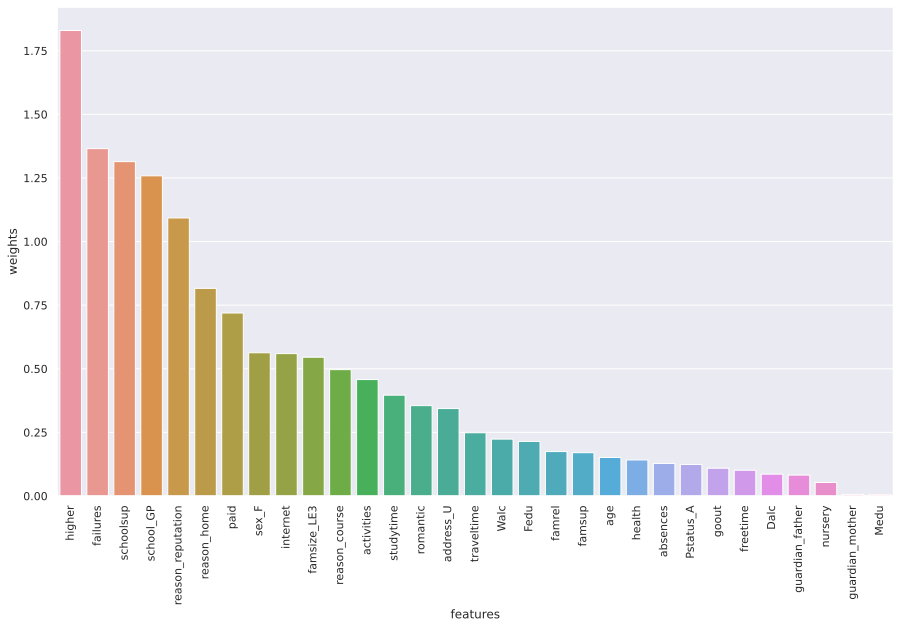

In [171]:
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_lr_coef, x='features', y='weights')
plt.xticks(rotation=90)
plt.show()

O peso das variáveis tem a seguintes 5 top features:

* Querer educação superior
* Failures passados
* Suplemento escolar 
* Ser da escola GP
* Ter escolhido a escola pela sua reputação

E se usarmos outro tipo de regressão?

In [172]:
# Ridge

ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(features_t_imp, target_t_imp)

feature_importances_rr_coef = pd.concat([pd.Series(features_t_imp.columns, name='features'), 
                                         pd.Series(ridge_reg.coef_, name='weights')],
                                        axis=1)

feature_importances_rr_coef['weights'] = abs(feature_importances_rr_coef['weights'])
feature_importances_rr_coef = feature_importances_rr_coef.sort_values(by='weights', ascending=False).reset_index(drop=True)

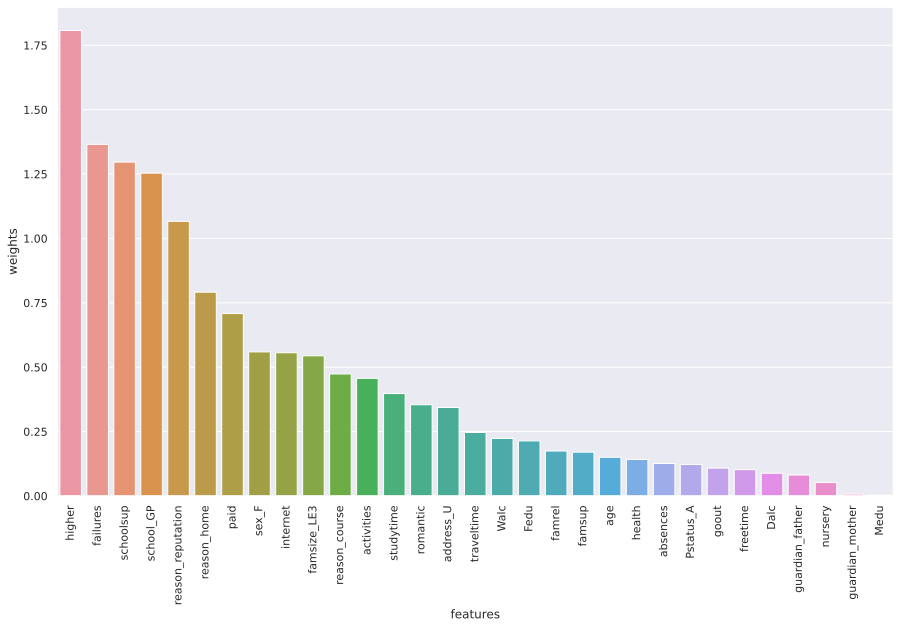

In [173]:
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_rr_coef, x='features', y='weights')
plt.xticks(rotation=90)
plt.show()

Ridge nos da as seguintes top 5 features:

* querer educação superior
* failures passados
* suplemento escolar
* ser da escola GP
* ter escohido a escola por sua reputação

In [174]:
# Lasso

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(features_t_imp, target_t_imp)


feature_importances_lr_coef = pd.concat([pd.Series(features_t_imp.columns, name='features'), 
                                         pd.Series(model_lasso.coef_, name='weights')],
                                        axis=1)

feature_importances_lr_coef['weights'] = abs(feature_importances_lr_coef['weights'])
feature_importances_lr_coef = feature_importances_lr_coef.sort_values(by='weights', ascending=False).reset_index(drop=True)

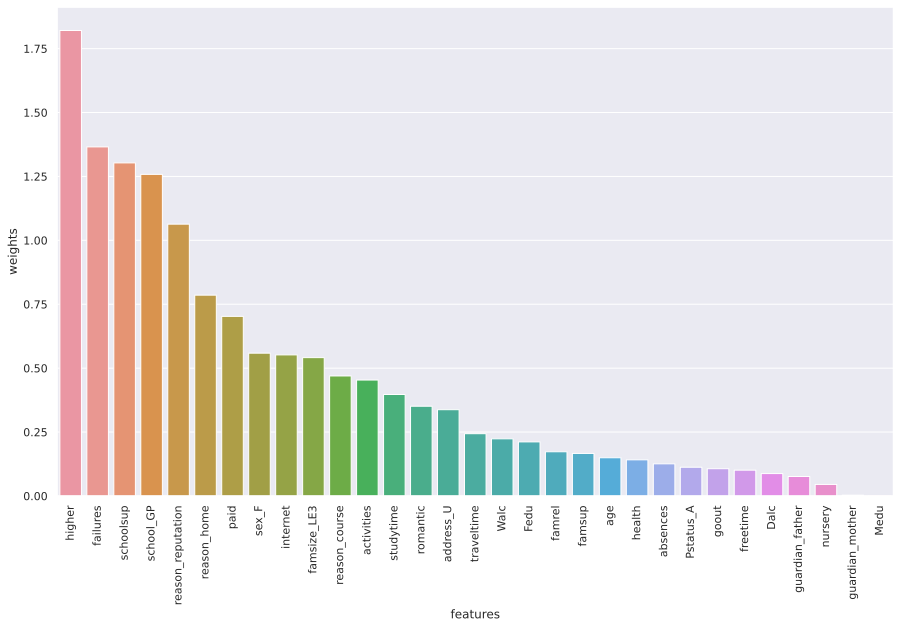

In [175]:
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_lr_coef, x='features', y='weights')
plt.xticks(rotation=90)
plt.show()

Lasso nos da as mesmas top 5 features de ridge:

* querer educação superior
* failures passados
* suplemento escolar
* ser da escola GP
* ter escohido a escola por sua reputação

A diferença aqui é que a regressão zera tanto a educação da mãe quanto a criança estar com a mãe.

## Modelos

Agora testarei, de modo simples, os modelos de melhor encaixe

## Matemática

In [176]:
x_train = train_mat.drop(['G3'], 1)
y_train = train_mat['G3']

x_test = test_mat.drop(['G3'], 1)
y_test = test_mat['G3']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [177]:
from sklearn.metrics import mean_absolute_error as mae

# definindo a métrica de acurácia
# optei por MAE porque esta medida não sofre com a divisão por 0, enquanto MAPE fica arbitrariamente alto quando há um 0 no y_test por conta da divisão

In [178]:
models = {    
          'Decision Tree': DecisionTreeRegressor(),
          'LinearRegresion': LinearRegression(),
          'Random Forest': RandomForestRegressor(),
          'Ridge': RidgeCV(),
          'LASSO': LassoCV(),
          'ElasticNet': ElasticNetCV(),    
          'Gradient Boosting': GradientBoostingRegressor(),
         }

for name in models:
    model = models[name]
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    print(f'{name}: {mae(prediction, y_test)}')

Decision Tree: 3.9327731092436973
LinearRegresion: 3.52642757307281
Random Forest: 2.687310924369748
Ridge: 3.292119552550319
LASSO: 3.053897531553256
ElasticNet: 3.0154722766638273
Gradient Boosting: 2.9708496710454075


Aqui vemos que Random Forest e Gradient Boosting foram os modelos que tiveram os menores erros.

Uma possibilidade de melhorarmos isso é pegarmos as features de maior importância dentro do treino (como vista acima com os coeficientes) para testar. 

Olhei as 5 mais importantes segundo a Reg Linear.

In [179]:
x_train_2 = x_train[['higher', 'schoolsup', 'romantic', 'failures', 'famsize_LE3']]
x_test_2 =  x_test[['higher', 'schoolsup', 'romantic', 'failures', 'famsize_LE3']]

In [180]:
models = {    
          'Decision Tree': DecisionTreeRegressor(),
          'LinearRegresion': LinearRegression(),
          'Random Forest': RandomForestRegressor(),
          'Ridge': RidgeCV(),
          'LASSO': LassoCV(),
          'ElasticNet': ElasticNetCV(),    
          'Gradient Boosting': GradientBoostingRegressor(),
         }

for name in models:
    model = models[name]
    model.fit(x_train_2, y_train)
    prediction = model.predict(x_test_2)
    print(f'{name}: {mae(prediction, y_test)}')

Decision Tree: 3.1846862156888323
LinearRegresion: 3.133124806387355
Random Forest: 3.0865105126766244
Ridge: 3.1083850071741153
LASSO: 3.1293175475364765
ElasticNet: 3.0428420371910723
Gradient Boosting: 3.153267992760938


O MAE de Ridge, LinearRegression e Decision Tree melhorara. Enquanto os outros, por mais que pouco, pioraram. 

## Português

In [181]:
x_train = train_por.drop(['G3'], 1)
y_train = train_por['G3']

x_test = test_por.drop(['G3'], 1)
y_test = test_por['G3']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [182]:
models = {    
          'Decision Tree': DecisionTreeRegressor(),
          'LinearRegresion': LinearRegression(),
          'Random Forest': RandomForestRegressor(),
          'Ridge': RidgeCV(),
          'LASSO': LassoCV(),
          'ElasticNet': ElasticNetCV(),    
          'Gradient Boosting': GradientBoostingRegressor(),
         }

for name in models:
    model = models[name]
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    print(f'{name}: {mae(prediction, y_test)}')

Decision Tree: 2.7948717948717947
LinearRegresion: 2.1299395884781367
Random Forest: 2.1666666666666665
Ridge: 2.113495230648637
LASSO: 2.0819836906193028
ElasticNet: 2.0916806271321926
Gradient Boosting: 2.18224403639899


In [183]:
# Agora com a top 5

x_train_2 = x_train[['higher', 'schoolsup', 'failures', 'school_GP', 'reason_reputation']]
x_test_2 =  x_test[['higher', 'schoolsup', 'failures', 'school_GP', 'reason_reputation']]

In [184]:
models = {    
          'Decision Tree': DecisionTreeRegressor(),
          'LinearRegresion': LinearRegression(),
          'Random Forest': RandomForestRegressor(),
          'Ridge': RidgeCV(),
          'LASSO': LassoCV(),
          'ElasticNet': ElasticNetCV(),    
          'Gradient Boosting': GradientBoostingRegressor(),
         }

for name in models:
    model = models[name]
    model.fit(x_train_2, y_train)
    prediction = model.predict(x_test_2)
    print(f'{name}: {mae(prediction, y_test)}')

Decision Tree: 2.241118462038058
LinearRegresion: 2.1539973732210664
Random Forest: 2.203393332169783
Ridge: 2.154999524672769
LASSO: 2.1553718893945217
ElasticNet: 2.1575457965581895
Gradient Boosting: 2.2171297201984976


Aqui, somente Decision Tree e Gradient Boosting melhoraram.


# **Exercício 3**



# Exercício 2 com Random Forest

## Matemática

In [185]:
features_t_imp = train_mat.copy().drop(['G3'], axis=1)
target_t_imp = train_mat.copy()['G3']

In [186]:
parameters = {'max_depth' : [8, 10, 12, 20],
              'n_estimators' : [200, 250, 300],
              'max_features' : [5, 25, 50],
              'min_samples_split' : [2, 4, 6]}
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state=42),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 5)
grid_search.fit(features_t_imp, target_t_imp)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/p

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [8, 10, 12, 20],
                         'max_features': [5, 25, 50],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [200, 250, 300]},
             scoring='neg_mean_squared_error')

In [187]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 25,
 'min_samples_split': 2,
 'n_estimators': 250}

In [188]:
regressor_rf = RandomForestRegressor(max_depth=20, n_estimators=250, max_features=25, min_samples_split=2, random_state=1)
regressor_rf.fit(features_t_imp, target_t_imp)

RandomForestRegressor(max_depth=20, max_features=25, n_estimators=250,
                      random_state=1)

In [189]:
feature_importances_rf = pd.concat([pd.Series(features_t_imp.columns, name='features'), 
                                    pd.Series(regressor_rf.feature_importances_, name='importance')],
                                    axis=1).sort_values(by='importance', ascending=False).reset_index(drop=True)

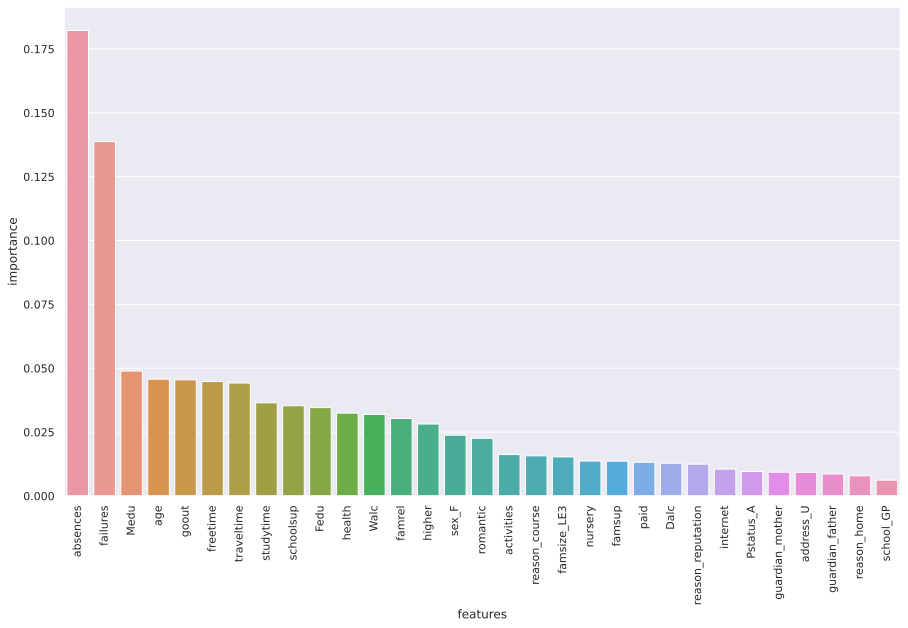

In [190]:
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_rf, x='features', y='importance')
plt.xticks(rotation=90)
plt.show()

Aqui, as top 5 features são:

* Faltas
* Failures passados
* Educação da mãe
* Idade
* O quanto sai com amigxs

## Será que muda o modelo?

In [191]:
x_train = train_mat.drop(['G3'], 1)
y_train = train_mat['G3']

x_test = test_mat.drop(['G3'], 1)
y_test = test_mat['G3']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [192]:
x_train_2 = x_train[['absences', 'failures', 'Medu', 'age', 'goout']]
x_test_2 =  x_test[['absences', 'failures', 'Medu', 'age', 'goout']]

In [193]:
models = {    
          'Decision Tree': DecisionTreeRegressor(),
          'LinearRegresion': LinearRegression(),
          'Random Forest': RandomForestRegressor(),
          'Ridge': RidgeCV(),
          'LASSO': LassoCV(),
          'ElasticNet': ElasticNetCV(),    
          'Gradient Boosting': GradientBoostingRegressor(),
         }

for name in models:
    model = models[name]
    model.fit(x_train_2, y_train)
    prediction = model.predict(x_test_2)
    print(f'{name}: {mae(prediction, y_test)}')

Decision Tree: 3.8892156862745098
LinearRegresion: 2.7904687218459623
Random Forest: 2.9413227584740187
Ridge: 2.789705512396568
LASSO: 2.7849384543736404
ElasticNet: 2.783611158131376
Gradient Boosting: 2.9058145565814852


O Mae da regressão linear, random forest, ridge, lasso, elastic net e gradient boost melhoram em relação aos modelos com as variáveis mais importantes segundo a regressão linear. 

Em relação ao modelo com todas as variáveis, apenas Random Forest piora em acurácia.

## Português

In [194]:
features_t_imp = train_por.copy().drop(['G3'], axis=1)
target_t_imp = train_por.copy()['G3']

In [195]:
parameters = {'max_depth' : [8, 10, 12, 20],
              'n_estimators' : [200, 250, 300],
              'max_features' : [5, 25, 50],
              'min_samples_split' : [2, 4, 6]}
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state=42),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 5)
grid_search.fit(features_t_imp, target_t_imp)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/p

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [8, 10, 12, 20],
                         'max_features': [5, 25, 50],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [200, 250, 300]},
             scoring='neg_mean_squared_error')

In [196]:
grid_search.best_params_

{'max_depth': 12,
 'max_features': 5,
 'min_samples_split': 6,
 'n_estimators': 300}

In [197]:
regressor_rf = RandomForestRegressor(max_depth=12, n_estimators=300, max_features=5, min_samples_split=6, random_state=1)
regressor_rf.fit(features_t_imp, target_t_imp)

feature_importances_rf = pd.concat([pd.Series(features_t_imp.columns, name='features'), 
                                    pd.Series(regressor_rf.feature_importances_, name='importance')],
                                    axis=1).sort_values(by='importance', ascending=False).reset_index(drop=True)

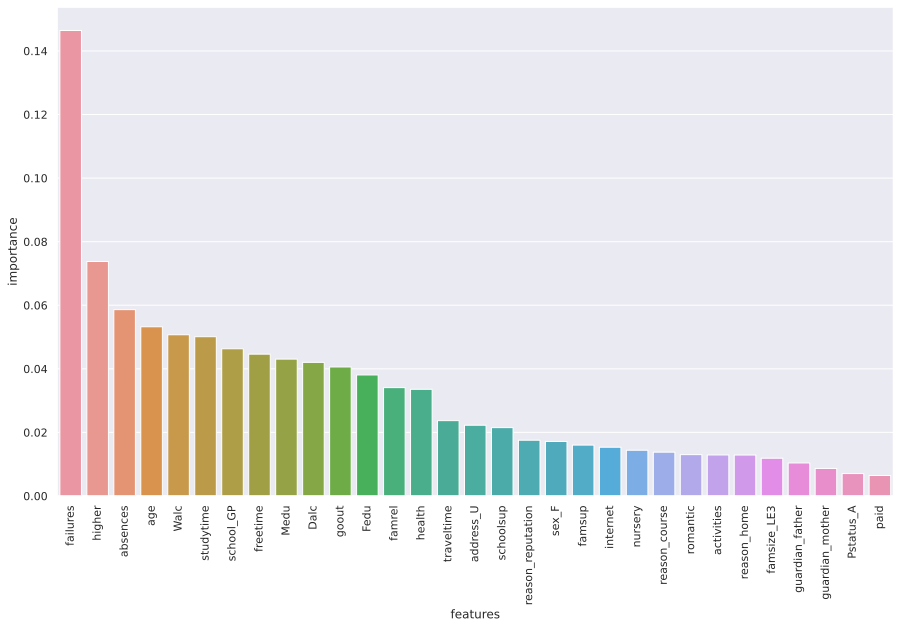

In [198]:
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_rf, x='features', y='importance')
plt.xticks(rotation=90)
plt.show()

Aqui, as top 5 features são 

* Failures passados
* Querer educação superior
* Faltas
* Idade
* Consumo de álcool em fins de semana 

## Será que muda o modelo?

In [199]:
x_train = train_por.drop(['G3'], 1)
y_train = train_por['G3']

x_test = test_por.drop(['G3'], 1)
y_test = test_por['G3']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [200]:
x_train_2 = x_train[['absences', 'failures', 'higher', 'age', 'Walc']]
x_test_2 =  x_test[['absences', 'failures', 'higher', 'age', 'Walc']]

In [201]:
models = {    
          'Decision Tree': DecisionTreeRegressor(),
          'LinearRegresion': LinearRegression(),
          'Random Forest': RandomForestRegressor(),
          'Ridge': RidgeCV(),
          'LASSO': LassoCV(),
          'ElasticNet': ElasticNetCV(),    
          'Gradient Boosting': GradientBoostingRegressor(),
         }

for name in models:
    model = models[name]
    model.fit(x_train_2, y_train)
    prediction = model.predict(x_test_2)
    print(f'{name}: {mae(prediction, y_test)}')

Decision Tree: 2.805982905982906
LinearRegresion: 2.254832415020636
Random Forest: 2.531450722476686
Ridge: 2.255384276262717
LASSO: 2.255926719662426
ElasticNet: 2.2567412893828505
Gradient Boosting: 2.3823589004453676


Em relação aos modelos com todas as variáveis, somente Decision Tree tem sua acurácia melhorada.

Em relação ao modelo com as principais variáveis da regressão linear, nenhuma acurácia é melhorada.

Em conclusão, a acurácia dos modelos não foi profundamente melhorada. Entretanto, é notável que há uma diferença na importância das variáveis dependendo do método utilizado: regressão aponta para um conjunto de características importantes diferente do que é apontando por random forest. Dentre as top 5, compartilham 3 variáveis - failures, absences e age. Entretanto, a classificação de importância das demais variáveis é diferente nos dois métodos. 